In [31]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer

# Load the dataset
df = pd.read_excel("data1-telematics_syn_orignal data.xlsx", index_col=0)

# Select relevant features for grouping and target variables
features_to_keep = [
    'Insured.age', 'Credit.score', 'Annual.miles.drive', 
    'Car.age', 'Years.noclaims', 'NB_Claim', 'AMT_Claim'
]
df_selected = df[features_to_keep].copy()

# Impute missing values
imputer = SimpleImputer(strategy='median')
df_selected.loc[:, df_selected.columns] = imputer.fit_transform(df_selected[df_selected.columns])

# Handle negative car age by replacing with 0
df_selected['Car.age'] = df_selected['Car.age'].apply(lambda x: max(x, 0))

# Group Binning
age_bin_list = [16, 25, 40, 60, df_selected['Insured.age'].max()]
age_bin_labels = ['16-25', '26-40', '41-60', '61+']
df_selected['age_group'] = pd.cut(df_selected['Insured.age'], bins=age_bin_list, labels=age_bin_labels, include_lowest=True)

# Define Credit Score Groups
credit_score_bins = [422, 600, 700, 800, 900]
credit_score_labels = ['Poor', 'Fair', 'Good', 'Excellent']
df_selected['credit_score_group'] = pd.cut(df_selected['Credit.score'], bins=credit_score_bins, labels=credit_score_labels, include_lowest=True)

# Update Annual mileage groups with the new buckets
annual_miles_bins = [0, 5000, 10000, 15000, 20000, 25000, df_selected['Annual.miles.drive'].max()]
annual_miles_labels = ['0-5k', '5k-10k', '10k-15k', '15k-20k', '20k-25k', '25k+']
df_selected['annual_miles_group'] = pd.cut(df_selected['Annual.miles.drive'], bins=annual_miles_bins, labels=annual_miles_labels, include_lowest=True)

# Define car age groups - max age of 20
car_age_bins = [0, 5, 10, 15, 20]
car_age_labels = ['0-5', '6-10', '11-15', '16-20']
df_selected['car_age_group'] = pd.cut(df_selected['Car.age'], bins=car_age_bins, labels=car_age_labels, include_lowest=True)

# Years no claims groups
years_noclaims_bins = [0, 10, 20, 30, 40, 50, df_selected['Years.noclaims'].max()]
years_noclaims_labels = ['0-10', '11-20', '21-30', '31-40', '41-50', '50+']
df_selected['years_noclaims_group'] = pd.cut(df_selected['Years.noclaims'], bins=years_noclaims_bins, labels=years_noclaims_labels, include_lowest=True)

# Drop the original numeric columns
df_final_prepared = df_selected.drop(columns=['Insured.age', 'Credit.score', 'Annual.miles.drive', 'Car.age', 'Years.noclaims'])

# Save the prepared data
df_final_prepared.to_csv('final_prepared_data.csv', index=False)


# CHECK FOR NAN VALUES

In [32]:
# Load the prepared dataset from previous preprocessing step
df_final_prepared = pd.read_csv('final_prepared_data_relative.csv')

# Check for NaN values across the entire DataFrame
nan_values = df_final_prepared.isnull().sum()

# Check for Inf values only in numeric columns
numeric_columns = df_final_prepared.select_dtypes(include=[np.number])
inf_values = numeric_columns.apply(lambda x: np.isinf(x).sum())

# Display the results
print("NaN values in each column:\n", nan_values)
print("\nInf values in numeric columns:\n", inf_values)


NaN values in each column:
 NB_Claim                0
AMT_Claim               0
age_group               0
credit_score_group      0
annual_miles_group      0
car_age_group           0
years_noclaims_group    0
relative_frequency      0
dtype: int64

Inf values in numeric columns:
 NB_Claim              0
AMT_Claim             0
relative_frequency    0
dtype: int64


# MODEL TRAINING

# GLM

In [33]:
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

"""
Training and predicting with GLM for each group in the dataset.
"""
glm_models = {}

def train_and_predict_glm_group(df, group_column):
    df_group = df[[group_column, 'NB_Claim', 'AMT_Claim']].dropna().copy()
    
    # Encode the group column
    df_group[group_column] = LabelEncoder().fit_transform(df_group[group_column])

    # Calculate the number of members in the level
    df_group['members_in_level'] = df_group.groupby(group_column)[group_column].transform('count')

    # Calculate the actual claim counts in the level
    df_group['actual_claim_counts'] = df_group.groupby(group_column)['NB_Claim'].transform('sum')

    # Severity: average claim amount in the level
    df_group['target_severity'] = df_group.groupby(group_column)['AMT_Claim'].transform('sum') / df_group['actual_claim_counts']
    
    # Relative frequency: average number of claims in the level
    df_group['target_relative_frequency'] = df_group.groupby(group_column)['NB_Claim'].transform('mean')

    X = df_group[[group_column]]
    y_claims = df_group['target_relative_frequency']

    # Add constant for intercept
    X = sm.add_constant(X)

    # Use KFold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    claims_predictions = np.zeros(len(X))

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train = y_claims.iloc[train_index]
        
        # Fit GLM for claims model
        model_claims = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
        claims_predictions[test_index] = model_claims.predict(X_test)

    df_group['predicted_claims'] = claims_predictions
    glm_models[group_column] = model_claims

    df_non_zero_claims = df_group[df_group['NB_Claim'] > 0].copy()
    if not df_non_zero_claims.empty:
        y_sev = df_non_zero_claims['target_severity']
        X_non_zero_claims = sm.add_constant(df_non_zero_claims[[group_column]])

        severity_predictions = np.zeros(len(X_non_zero_claims))

        for train_index, test_index in kf.split(X_non_zero_claims):
            X_train, X_test = X_non_zero_claims.iloc[train_index], X_non_zero_claims.iloc[test_index]
            y_train = y_sev.iloc[train_index]
            
            # Fit GLM for severity model
            model_sev = sm.GLM(y_train, X_train, family=sm.families.Gaussian()).fit()
            severity_predictions[test_index] = model_sev.predict(X_test)

        df_non_zero_claims['predicted_severity'] = severity_predictions
        glm_models[f"{group_column}_severity"] = model_sev
    else:
        df_non_zero_claims['predicted_severity'] = None

    results = df_group.groupby(group_column).agg(
        actual_frequency=('target_relative_frequency', 'mean'),
        predicted_frequency=('predicted_claims', 'mean'),
        actual_severity=('target_severity', 'mean')
    ).reset_index()

    if not df_non_zero_claims.empty:
        severity_results = df_non_zero_claims.groupby(group_column).agg(
            predicted_severity=('predicted_severity', 'mean')
        ).reset_index()
        results = pd.merge(results, severity_results, on=group_column, how='left')

    results['model'] = 'glm'
    results['group'] = group_column
    results.rename(columns={group_column: 'level'}, inplace=True)

    return results[['model', 'group', 'level', 'actual_frequency', 'predicted_frequency', 'actual_severity', 'predicted_severity']]

# Load the prepared dataset
df = pd.read_csv('final_prepared_data.csv')
groups_of_interest = ['age_group', 'credit_score_group', 'annual_miles_group', 'car_age_group', 'years_noclaims_group']
results_list = []
for group in groups_of_interest:
    print(f"Training and predicting for group '{group}'")
    results_list.append(train_and_predict_glm_group(df, group))

final_results = pd.concat(results_list, axis=0)
final_results.to_csv('glm_group_prediction_results.csv', index=False)
print("Results saved to 'glm_group_prediction_results.csv'")


Training and predicting for group 'age_group'
Training and predicting for group 'credit_score_group'
Training and predicting for group 'annual_miles_group'
Training and predicting for group 'car_age_group'
Training and predicting for group 'years_noclaims_group'
Results saved to 'glm_group_prediction_results.csv'


## GAM

In [34]:
from pygam import PoissonGAM, LinearGAM, s
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
"""
Function to train and predict a Poisson GAM model for a given group column
"""

def train_and_predict_gam_group(df, group_column):
    df_group = df[[group_column, 'NB_Claim', 'AMT_Claim']].dropna().copy()
    
    # Encode the group column
    df_group[group_column] = LabelEncoder().fit_transform(df_group[group_column])
    
    # Calculate the number of members in the level
    df_group['members_in_level'] = df_group.groupby(group_column)[group_column].transform('count')
    
    # Calculate the actual claim counts in the level
    df_group['actual_claim_counts'] = df_group.groupby(group_column)['NB_Claim'].transform('sum')
    
    # Severity: average claim amount in the level
    df_group['target_severity'] = df_group.groupby(group_column)['AMT_Claim'].transform('sum') / df_group['actual_claim_counts']
    
    # Relative frequency: average number of claims in the level / proportion of members in the level
    df_group['target_relative_frequency'] = df_group.groupby(group_column)['NB_Claim'].transform('mean')
    
    X = df_group[[group_column]].values
    y_claims = df_group['target_relative_frequency'].values

    # Perform grid search to find the best lambda for the Poisson GAM
    gam_freq = PoissonGAM(s(0, n_splines=5, lam=0.6))
    lam_range = {'lam': [0.1, 0.3, 0.6, 1.0, 3.0]}
    grid_search = GridSearchCV(gam_freq, lam_range, cv=10, scoring='neg_mean_squared_error')
    grid_search.fit(X, y_claims)
    best_gam_freq = grid_search.best_estimator_
    df_group['predicted_claims'] = best_gam_freq.predict(X)

    frequency_rmse = np.sqrt(np.mean((df_group['target_relative_frequency'] - df_group['predicted_claims'])**2))
    print(f"Frequency RMSE for group '{group_column}': {frequency_rmse}")    
    df_non_zero_claims = df_group[df_group['NB_Claim'] > 0].copy()

    if not df_non_zero_claims.empty:        
        X_sev = df_non_zero_claims[[group_column]].values
        y_sev = df_non_zero_claims['target_severity'].values
        gam_sev = LinearGAM(s(0, n_splines=5, lam=0.6)).fit(X_sev, y_sev)
        df_non_zero_claims['predicted_severity'] = gam_sev.predict(X_sev)

        severity_rmse = np.sqrt(np.mean((df_non_zero_claims['target_severity'] - df_non_zero_claims['predicted_severity'])**2))
        print(f"Severity RMSE for group '{group_column}': {severity_rmse}")
    else:
        df_non_zero_claims['predicted_severity'] = None
        severity_rmse = None
        print(f"No severity RMSE for group '{group_column}' as there are no non-zero claims.")

    # Aggregate the results
    results = df_group.groupby(group_column).agg(
        actual_frequency=('target_relative_frequency', 'mean'),
        predicted_frequency=('predicted_claims', 'mean'),
        actual_severity=('target_severity', 'mean')
    ).reset_index()

    if not df_non_zero_claims.empty:
        severity_results = df_non_zero_claims.groupby(group_column).agg(
            predicted_severity=('predicted_severity', 'mean')
        ).reset_index()
        results = pd.merge(results, severity_results, on=group_column, how='left')

    # Add the model and group columns
    results['model'] = 'gam'
    results['group'] = group_column
    results = results[['model', 'group', group_column, 'actual_frequency', 'predicted_frequency', 'actual_severity', 'predicted_severity']]
    results.rename(columns={group_column: 'level'}, inplace=True)

    return results

# Load the prepared dataset
df = pd.read_csv('final_prepared_data.csv')

groups_of_interest = ['age_group', 'credit_score_group', 'annual_miles_group', 'car_age_group', 'years_noclaims_group']
results_list = []
for group in groups_of_interest:
    print(f"Training and predicting for group '{group}'")
    results_list.append(train_and_predict_gam_group(df, group))

final_results = pd.concat(results_list, axis=0)
final_results.to_csv('gam_group_prediction_results.csv', index=False)
print("Results saved to 'gam_group_prediction_results.csv'")


Training and predicting for group 'age_group'
Frequency RMSE for group 'age_group': 0.012916135875311542
Severity RMSE for group 'age_group': 13.928380705533216
Training and predicting for group 'credit_score_group'
Frequency RMSE for group 'credit_score_group': 0.017917702257279237
Severity RMSE for group 'credit_score_group': 142.36626912699373
Training and predicting for group 'annual_miles_group'
Frequency RMSE for group 'annual_miles_group': 0.009862703783068605
Severity RMSE for group 'annual_miles_group': 155.7112852407971
Training and predicting for group 'car_age_group'
Frequency RMSE for group 'car_age_group': 0.01186197828232804
Severity RMSE for group 'car_age_group': 39.69665170187454
Training and predicting for group 'years_noclaims_group'
Frequency RMSE for group 'years_noclaims_group': 0.014393837731666206
Severity RMSE for group 'years_noclaims_group': 132.22757415328363
Results saved to 'gam_group_prediction_results.csv'


## XGBOOST

In [35]:
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np

"""
Training and predicting with XGBoost for each group in the dataset.
"""
xgb_models = {}

def train_and_predict_xgboost_group(df, group_column):
    df_group = df[[group_column, 'NB_Claim', 'AMT_Claim']].dropna().copy()
    
    # Encode the group column
    df_group[group_column] = LabelEncoder().fit_transform(df_group[group_column])

    # Calculate the number of members in the level
    df_group['members_in_level'] = df_group.groupby(group_column)[group_column].transform('count')

    # Calculate the actual claim counts in the level
    df_group['actual_claim_counts'] = df_group.groupby(group_column)['NB_Claim'].transform('sum')

    # Severity: average claim amount in the level
    df_group['target_severity'] = df_group.groupby(group_column)['AMT_Claim'].transform('sum') / df_group['actual_claim_counts']
    
    # Relative frequency: average number of claims in the level / proportion of members in the level
    df_group['target_relative_frequency'] = df_group.groupby(group_column)['NB_Claim'].transform('mean')

    X = df_group[[group_column]]
    y_claims = df_group['target_relative_frequency']

    # Use KFold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    model_claims = xgb.XGBRegressor(
        objective='reg:squarederror',
        verbosity=1,
        max_depth=3,
        learning_rate=0.01,
        n_estimators=500,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.5,
        reg_lambda=1.0
    )
    
    # Cross-validation for claims model
    scores = cross_val_score(model_claims, X, y_claims, cv=kf, scoring='neg_mean_squared_error')
    print(f"Cross-Validation RMSE for {group_column}: {np.sqrt(-scores.mean()):.4f}")
    model_claims.fit(X, y_claims)
    df_group['predicted_claims'] = model_claims.predict(X)
    xgb_models[group_column] = model_claims
    model_claims.save_model(f"{group_column}_xgb_model.json")

    df_non_zero_claims = df_group[df_group['NB_Claim'] > 0].copy()
    if not df_non_zero_claims.empty:
        y_sev = df_non_zero_claims['target_severity']

        model_sev = xgb.XGBRegressor(
            objective='reg:squarederror',
            verbosity=1,
            max_depth=3,
            learning_rate=0.01,
            n_estimators=500,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=0.5,
            reg_lambda=1.0
        )
        
        # Cross-validation for severity model
        scores_sev = cross_val_score(model_sev, X.loc[df_non_zero_claims.index], y_sev, cv=kf, scoring='neg_mean_squared_error')
        print(f"Cross-Validation RMSE for Severity {group_column}: {np.sqrt(-scores_sev.mean()):.4f}")
        
        model_sev.fit(X.loc[df_non_zero_claims.index], y_sev)
        df_non_zero_claims['predicted_severity'] = model_sev.predict(X.loc[df_non_zero_claims.index])
        xgb_models[f"{group_column}_severity"] = model_sev
        model_sev.save_model(f"{group_column}_xgb_severity_model.json")
    else:
        df_non_zero_claims['predicted_severity'] = None

    results = df_group.groupby(group_column).agg(
        actual_frequency=('target_relative_frequency', 'mean'),
        predicted_frequency=('predicted_claims', 'mean'),
        actual_severity=('target_severity', 'mean')
    ).reset_index()

    if not df_non_zero_claims.empty:
        severity_results = df_non_zero_claims.groupby(group_column).agg(
            predicted_severity=('predicted_severity', 'mean')
        ).reset_index()
        results = pd.merge(results, severity_results, on=group_column, how='left')

    results['model'] = 'xgboost'
    results['group'] = group_column
    results.rename(columns={group_column: 'level'}, inplace=True)

    return results[['model', 'group', 'level', 'actual_frequency', 'predicted_frequency', 'actual_severity', 'predicted_severity']]

# Load the prepared dataset
df = pd.read_csv('final_prepared_data.csv')
groups_of_interest = ['age_group', 'credit_score_group', 'annual_miles_group', 'car_age_group', 'years_noclaims_group']
results_list = []
for group in groups_of_interest:
    print(f"Training and predicting for group '{group}'")
    results_list.append(train_and_predict_xgboost_group(df, group))

final_results = pd.concat(results_list, axis=0)
final_results.to_csv('xgboost_group_prediction_results.csv', index=False)
print("Results saved to 'xgboost_group_prediction_results.csv'")


Training and predicting for group 'age_group'
Cross-Validation RMSE for age_group: 0.0001
Cross-Validation RMSE for Severity age_group: 3.9096
Training and predicting for group 'credit_score_group'
Cross-Validation RMSE for credit_score_group: 0.0002
Cross-Validation RMSE for Severity credit_score_group: 5.8823
Training and predicting for group 'annual_miles_group'
Cross-Validation RMSE for annual_miles_group: 0.0002
Cross-Validation RMSE for Severity annual_miles_group: 2.5423
Training and predicting for group 'car_age_group'
Cross-Validation RMSE for car_age_group: 0.0002
Cross-Validation RMSE for Severity car_age_group: 2.0354
Training and predicting for group 'years_noclaims_group'
Cross-Validation RMSE for years_noclaims_group: 0.0001
Cross-Validation RMSE for Severity years_noclaims_group: 5.0402
Results saved to 'xgboost_group_prediction_results.csv'


## LIGHTGBM

In [36]:
import lightgbm as lgb
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np

"""
Train and predict using LightGBM models for each group in the dataset.    
"""
lgb_models = {}

def train_and_predict_lightgbm_group(df, group_column):
    df_group = df[[group_column, 'NB_Claim', 'AMT_Claim']].dropna().copy()
    
    # Encode the group column
    df_group[group_column] = LabelEncoder().fit_transform(df_group[group_column])
    
    # Calculate the number of members in the level
    df_group['members_in_level'] = df_group.groupby(group_column)[group_column].transform('count')
    
    # Calculate the actual claim counts in the level
    df_group['actual_claim_counts'] = df_group.groupby(group_column)['NB_Claim'].transform('sum')
    
    # Severity: average claim amount in the level
    df_group['target_severity'] = df_group.groupby(group_column)['AMT_Claim'].transform('sum') / df_group['actual_claim_counts']
    
    # Relative frequency: average number of claims in the level / proportion of members in the level
    df_group['target_relative_frequency'] = df_group.groupby(group_column)['NB_Claim'].transform('mean')
    
    X = df_group[[group_column]]
    y_claims = df_group['target_relative_frequency']

    # Define the model parameters
    params_claims = {
        'objective': 'regression',
        'metric': 'l2',
        'learning_rate': 0.01,
        'num_leaves': 31,
        'max_depth': 5,
        'n_estimators': 500,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'reg_alpha': 0.5,
        'reg_lambda': 1.0,
        'verbosity': -1
    }

    # KFold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    model_claims = lgb.LGBMRegressor(**params_claims)
    scores = cross_val_score(model_claims, X, y_claims, cv=kf, scoring='neg_mean_squared_error')
    print(f"Cross-Validation RMSE for {group_column}: {np.sqrt(-scores.mean()):.4f}")
    
    # Fit the claims model
    model_claims.fit(X, y_claims)
    df_group['predicted_claims'] = model_claims.predict(X)
    lgb_models[group_column] = model_claims

    df_non_zero_claims = df_group[df_group['NB_Claim'] > 0].copy()
    if not df_non_zero_claims.empty:
        y_sev = df_non_zero_claims['target_severity']
        
        # Train the severity model
        model_sev = lgb.LGBMRegressor(**params_claims)
        scores_sev = cross_val_score(model_sev, X.loc[df_non_zero_claims.index], y_sev, cv=kf, scoring='neg_mean_squared_error')
        print(f"Cross-Validation RMSE for Severity {group_column}: {np.sqrt(-scores_sev.mean()):.4f}")        
        model_sev.fit(X.loc[df_non_zero_claims.index], y_sev)
        df_non_zero_claims['predicted_severity'] = model_sev.predict(X.loc[df_non_zero_claims.index])
    else:
        df_non_zero_claims['predicted_severity'] = None

    results = df_group.groupby(group_column).agg(
        actual_frequency=('target_relative_frequency', 'mean'),
        predicted_frequency=('predicted_claims', 'mean'),
        actual_severity=('target_severity', 'mean')
    ).reset_index()

    if not df_non_zero_claims.empty:
        severity_results = df_non_zero_claims.groupby(group_column).agg(
            predicted_severity=('predicted_severity', 'mean')
        ).reset_index()
        results = pd.merge(results, severity_results, on=group_column, how='left')

    results['model'] = 'lightgbm'
    results['group'] = group_column
    results.rename(columns={group_column: 'level'}, inplace=True)
    return results[['model', 'group', 'level', 'actual_frequency', 'predicted_frequency', 'actual_severity', 'predicted_severity']]

# Load the prepared dataset
df = pd.read_csv('final_prepared_data.csv')
groups_of_interest = ['age_group', 'credit_score_group', 'annual_miles_group', 'car_age_group', 'years_noclaims_group']

results_list = []
for group in groups_of_interest:
    print(f"Training and predicting for group '{group}'")
    results_list.append(train_and_predict_lightgbm_group(df, group))

final_results = pd.concat(results_list, axis=0)
final_results.to_csv('lightgbm_group_prediction_results.csv', index=False)
print("Results saved to 'lightgbm_group_prediction_results.csv'")


Training and predicting for group 'age_group'
Cross-Validation RMSE for age_group: 0.0001
Cross-Validation RMSE for Severity age_group: 3.9002
Training and predicting for group 'credit_score_group'
Cross-Validation RMSE for credit_score_group: 0.0002
Cross-Validation RMSE for Severity credit_score_group: 5.8694
Training and predicting for group 'annual_miles_group'
Cross-Validation RMSE for annual_miles_group: 0.0002
Cross-Validation RMSE for Severity annual_miles_group: 94.9169
Training and predicting for group 'car_age_group'
Cross-Validation RMSE for car_age_group: 0.0001
Cross-Validation RMSE for Severity car_age_group: 2.1668
Training and predicting for group 'years_noclaims_group'
Cross-Validation RMSE for years_noclaims_group: 0.0001
Cross-Validation RMSE for Severity years_noclaims_group: 5.0220
Results saved to 'lightgbm_group_prediction_results.csv'


# Results comparison

## Combine data points across models

In [37]:
# Load the results from all models
models = ['glm','gam', 'xgboost', 'lightgbm']
results = []
for model in models:
    file_name = f'{model}_group_prediction_results.csv'
    df = pd.read_csv(file_name)
    df['model'] = model
    results.append(df)

# Combine the results from all models
combined_results = pd.concat(results, axis=0)
def map_levels(df):
    mapping_dict = {
        'age_group': {0: '16-25', 1: '26-40', 2: '41-60', 3: '61+'},
        'credit_score_group': {0: 'Poor', 1: 'Fair', 2: 'Good', 3: 'Excellent'},
        'annual_miles_group': {0: '0-5000', 1: '5000-10000', 2: '10000-15000', 3: '15000-20000', 4: '20000-25000', 5: '25000+'},
        'car_age_group': {0: '0-5', 1: '6-10', 2: '11-15', 3: '16-20'},
        'years_noclaims_group': {0: '0-10', 1: '11-20', 2: '21-30', 3: '31-40', 4: '41-50', 5: '50+'}
    }
    for group, mapping in mapping_dict.items():
        df.loc[df['group'] == group, 'level'] = df.loc[df['group'] == group, 'level'].map(mapping)
    return df

combined_results = map_levels(combined_results)
# Convert the frequency values to percentages
combined_results['actual_frequency'] *= 100
combined_results['predicted_frequency'] *= 100

combined_results.to_csv('combined_model_comparison_results.csv', index=False)
print("Combined results saved to 'combined_model_comparison_results.csv'")


Combined results saved to 'combined_model_comparison_results.csv'


/var/folders/9t/ttq9f0sd08567xh5d9b7lmvw0000gn/T/ipykernel_38790/1704875156.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['16-25' '26-40' '41-60' '61+' '16-25' '26-40' '41-60' '61+' '16-25'
 '26-40' '41-60' '61+' '16-25' '26-40' '41-60' '61+']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df['group'] == group, 'level'] = df.loc[df['group'] == group, 'level'].map(mapping)


## Visualize Predictions vs Actual

In [38]:
# Load the combined results
combined_results = pd.read_csv('combined_model_comparison_results.csv')
print(combined_results.head())


  model               group  level  actual_frequency  predicted_frequency  \
0   glm           age_group  16-25          7.892617             8.079205   
1   glm           age_group  26-40          5.414107             5.923128   
2   glm           age_group  41-60          4.971112             4.342423   
3   glm           age_group    61+          2.752971             3.183604   
4   glm  credit_score_group   Poor          3.189221             3.453250   

   actual_severity  predicted_severity  
0      3947.332005         4254.873851  
1      3539.987434         3582.740306  
2      3094.832777         2911.187296  
3      1965.899739         2240.003493  
4      2201.423107         2453.116037  


Processing group: age_group


<Figure size 1200x800 with 0 Axes>

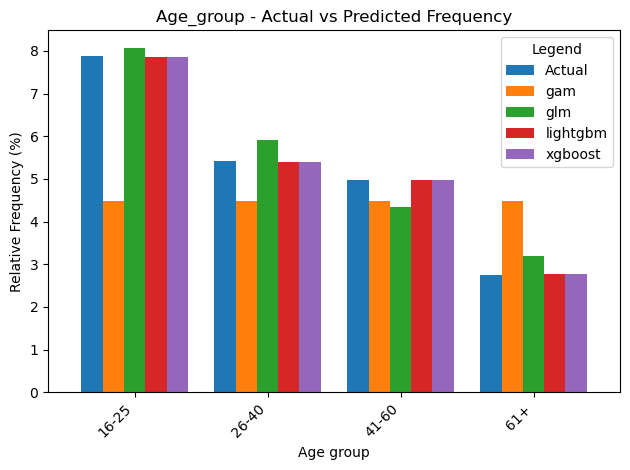

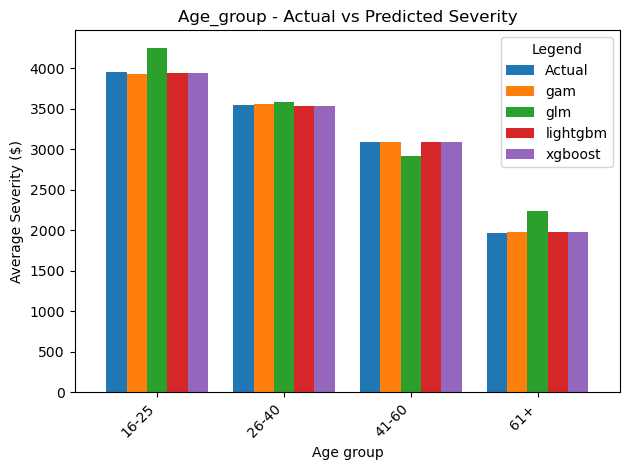

Summary table saved to age_group_summary_results.csv
Summary table for Age_group:

   model level  actual_frequency  predicted_frequency  actual_severity  predicted_severity
     glm 16-25          7.892617             8.079205      3947.332005         4254.873851
     glm 26-40          5.414107             5.923128      3539.987434         3582.740306
     glm 41-60          4.971112             4.342423      3094.832777         2911.187296
     glm   61+          2.752971             3.183604      1965.899739         2240.003493
     gam 16-25          7.892617             4.494000      3947.332005         3925.603603
     gam 26-40          5.414107             4.494000      3539.987434         3556.782175
     gam 41-60          4.971112             4.494000      3094.832777         3083.176642
     gam   61+          2.752971             4.494000      1965.899739         1976.242411
 xgboost 16-25          7.892617             7.850330      3947.332005         3941.383000
 xgboos

<Figure size 1200x800 with 0 Axes>

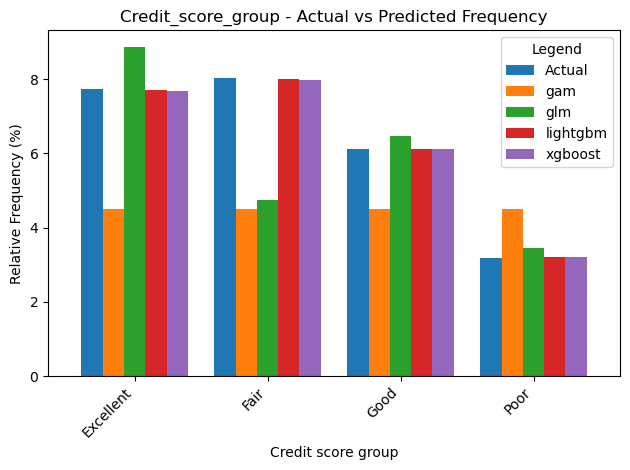

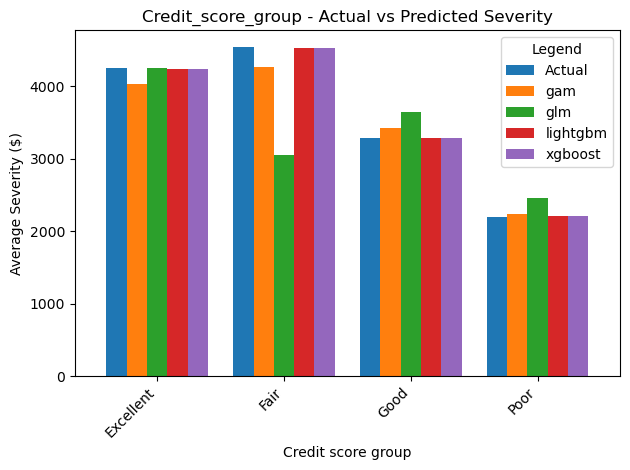

Summary table saved to credit_score_group_summary_results.csv
Summary table for Credit_score_group:

   model     level  actual_frequency  predicted_frequency  actual_severity  predicted_severity
     glm      Poor          3.189221             3.453250      2201.423107         2453.116037
     glm      Fair          8.021571             4.729154      4546.727669         3050.853061
     glm      Good          6.126081             6.476574      3292.986411         3649.316381
     glm Excellent          7.734655             8.869616      4254.692575         4247.648222
     gam      Poor          3.189221             4.494000      2201.423107         2233.027457
     gam      Fair          8.021571             4.494000      4546.727669         4272.370826
     gam      Good          6.126081             4.494000      3292.986411         3419.696448
     gam Excellent          7.734655             4.494000      4254.692575         4035.102988
 xgboost      Poor          3.189221        

<Figure size 1200x800 with 0 Axes>

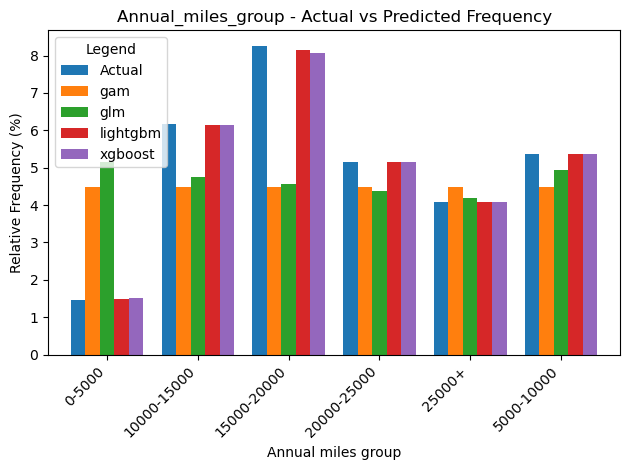

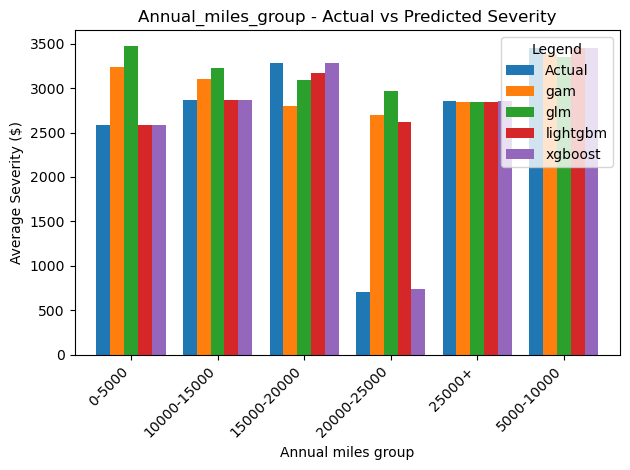

Summary table saved to annual_miles_group_summary_results.csv
Summary table for Annual_miles_group:

   model       level  actual_frequency  predicted_frequency  actual_severity  predicted_severity
     glm      0-5000          1.468531             5.148149      2584.954269         3476.729487
     glm  5000-10000          5.369355             4.943013      3451.430933         3347.985646
     glm 10000-15000          6.160015             4.746206      2867.525664         3221.402443
     glm 15000-20000          8.260870             4.557343      3280.218033         3094.626212
     glm 20000-25000          5.164319             4.375899       707.883233         2968.944197
     glm      25000+          4.079823             4.201751      2853.391108         2841.695449
     gam      0-5000          1.468531             4.494000      2584.954269         3236.985525
     gam  5000-10000          5.369355             4.494000      3451.430933         3385.520869
     gam 10000-15000      

<Figure size 1200x800 with 0 Axes>

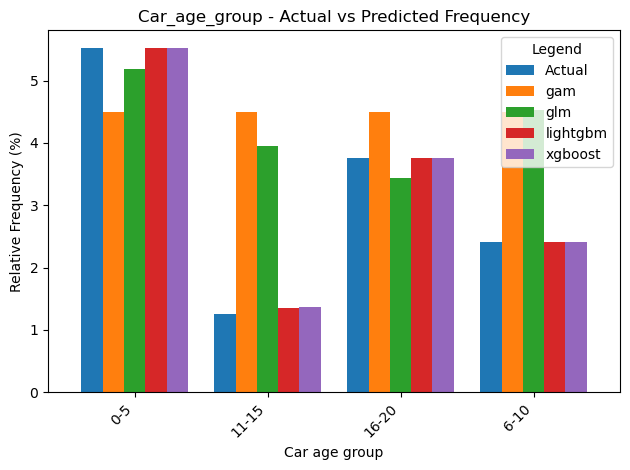

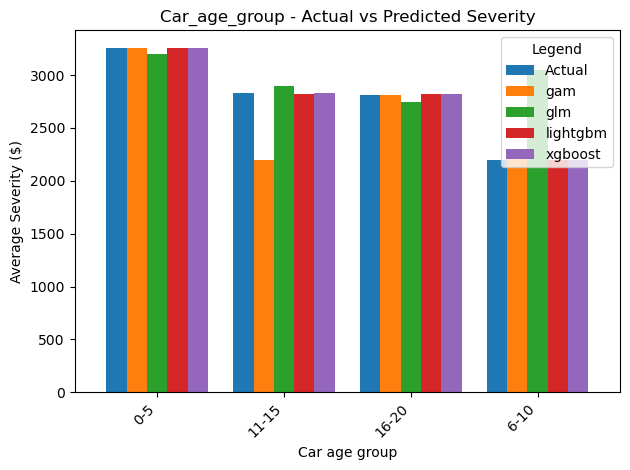

Summary table saved to car_age_group_summary_results.csv
Summary table for Car_age_group:

   model level  actual_frequency  predicted_frequency  actual_severity  predicted_severity
     glm   0-5          5.530182             5.181397      3259.807536         3201.476555
     glm  6-10          2.403728             4.521052      2194.710608         3050.207240
     glm 11-15          1.261564             3.944845      2827.348907         2898.767747
     glm 16-20          3.758228             3.442067      2814.362359         2747.362088
     gam   0-5          5.530182             4.494000      3259.807536         3257.407792
     gam  6-10          2.403728             4.494000      2194.710608         2246.743575
     gam 11-15          1.261564             4.494000      2827.348907         2197.487946
     gam 16-20          3.758228             4.494000      2814.362359         2815.524631
 xgboost   0-5          5.530182             5.522191      3259.807536         3258.503200

<Figure size 1200x800 with 0 Axes>

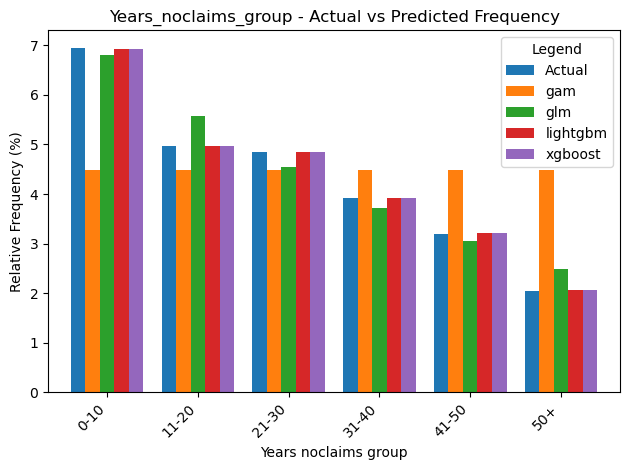

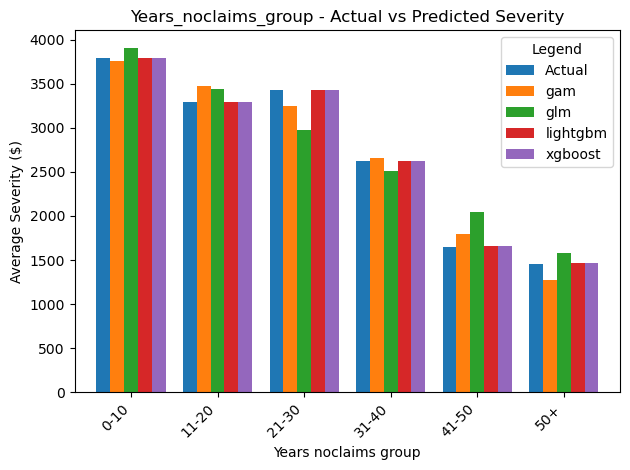

Summary table saved to years_noclaims_group_summary_results.csv
Summary table for Years_noclaims_group:

   model level  actual_frequency  predicted_frequency  actual_severity  predicted_severity
     glm  0-10          6.954974             6.802485      3790.817800         3909.170736
     glm 11-20          4.970470             5.564363      3295.919800         3443.425157
     glm 21-30          4.853854             4.551548      3429.305019         2976.951380
     glm 31-40          3.917085             3.723106      2621.008284         2511.487380
     glm 41-50          3.195731             3.045460      1650.880930         2045.551189
     glm   50+          2.045810             2.491169      1458.064784         1580.207885
     gam  0-10          6.954974             4.494000      3790.817800         3755.077327
     gam 11-20          4.970470             4.494000      3295.919800         3469.123315
     gam 21-30          4.853854             4.494000      3429.305019      

In [39]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the combined results
combined_results = pd.read_csv('combined_model_comparison_results.csv')

def plot_grouped_bar_chart(group_name, y_label_freq, y_label_sev, title_suffix, filename_suffix):
    plt.figure(figsize=(12, 8))
    
    # Filter data for the group
    plot_data = combined_results[combined_results['group'] == group_name].copy()
    
    # Get unique levels and models
    levels = plot_data['level'].unique()
    models = plot_data['model'].unique()
    plot_rows_freq = []
    plot_rows_sev = []
    
    for level in levels:
        actual_freq = plot_data.loc[plot_data['level'] == level, 'actual_frequency'].values[0]
        actual_sev = plot_data.loc[plot_data['level'] == level, 'actual_severity'].values[0]
        plot_rows_freq.append({'Level': level, 'Type': 'Actual', 'Value': actual_freq})
        plot_rows_sev.append({'Level': level, 'Type': 'Actual', 'Value': actual_sev})        
        
        for model in models:
            predicted_freq = plot_data.loc[(plot_data['level'] == level) & (plot_data['model'] == model), 'predicted_frequency'].values[0]
            predicted_sev = plot_data.loc[(plot_data['level'] == level) & (plot_data['model'] == model), 'predicted_severity'].values[0]
            plot_rows_freq.append({'Level': level, 'Type': model, 'Value': predicted_freq})
            plot_rows_sev.append({'Level': level, 'Type': model, 'Value': predicted_sev})
    
    # Create DataFrames for plotting
    freq_df = pd.DataFrame(plot_rows_freq)
    sev_df = pd.DataFrame(plot_rows_sev)
    
    # Pivot the DataFrames for plotting
    pivot_freq = freq_df.pivot(index='Level', columns='Type', values='Value')
    pivot_sev = sev_df.pivot(index='Level', columns='Type', values='Value')

    # Plot the grouped bar chart for Frequency
    pivot_freq.plot(kind='bar', width=0.8)
    plt.title(f'{group_name.capitalize()} - {title_suffix} Frequency')
    plt.ylabel(y_label_freq)
    plt.xlabel(group_name.replace('_', ' ').capitalize())
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Legend')
    plt.tight_layout()
    plt.savefig(f'{group_name}_frequency_{filename_suffix}.png')
    plt.show()

    # Plot the grouped bar chart for Severity
    pivot_sev.plot(kind='bar', width=0.8)
    plt.title(f'{group_name.capitalize()} - {title_suffix} Severity')
    plt.ylabel(y_label_sev)
    plt.xlabel(group_name.replace('_', ' ').capitalize())
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Legend')
    plt.tight_layout()
    plt.savefig(f'{group_name}_severity_{filename_suffix}.png')
    plt.show()

    # Save summary table to CSV
    summary_table = plot_data[['model', 'level', 'actual_frequency', 'predicted_frequency', 'actual_severity', 'predicted_severity']]
    summary_csv_filename = f'{group_name}_summary_results.csv'
    summary_table.to_csv(summary_csv_filename, index=False)
    print(f"Summary table saved to {summary_csv_filename}")

    return summary_table

# Define the groups for plotting
groups = ['age_group', 'credit_score_group', 'annual_miles_group', 'car_age_group', 'years_noclaims_group']
for group in groups:
    print(f"Processing group: {group}")
    summary_table = plot_grouped_bar_chart(
        group_name=group,
        y_label_freq='Relative Frequency (%)',
        y_label_sev='Average Severity ($)',
        title_suffix='Actual vs Predicted',
        filename_suffix='comparison'
    )    
    print(f"Summary table for {group.capitalize()}:\n")
    print(summary_table.to_string(index=False))
    print("\n" + "-" * 80 + "\n")


## CALCULATE PERFORMACE METRICS

In [40]:
def compute_accuracy_metrics_by_level(summary_csv_filename):
    """Compute RMSE and MAE for each level within the group."""
    print(f"Processing file: {summary_csv_filename}")
    summary_df = pd.read_csv(summary_csv_filename)
    
    if 'group' not in summary_df.columns:
        summary_df['group'] = summary_csv_filename.replace('_summary_results.csv', '').replace('_', ' ')

    results = []
    for _, row in summary_df.iterrows():
        frequency_rmse = np.sqrt((row['actual_frequency'] - row['predicted_frequency'])**2)
        frequency_mae = abs(row['actual_frequency'] - row['predicted_frequency'])
        severity_rmse = np.sqrt((row['actual_severity'] - row['predicted_severity'])**2)
        severity_mae = abs(row['actual_severity'] - row['predicted_severity'])

        results.append({
            'model_name': row['model'],
            'group': row['group'],
            'level': row['level'],
            'frequency_rmse': frequency_rmse,
            'frequency_mae': frequency_mae,
            'severity_rmse': severity_rmse,
            'severity_mae': severity_mae
        })
    
    accuracy_df = pd.DataFrame(results)
    accuracy_csv_filename = summary_csv_filename.replace('_summary_results.csv', '_accuracy_results.csv')
    accuracy_df.to_csv(accuracy_csv_filename, index=False)
    print(f"Accuracy metrics by level saved to {accuracy_csv_filename}")
    
    return accuracy_df

def compute_accuracy_metrics_all_levels(summary_csv_filename):
    """Compute and save RMSE and MAE for all levels across each group, for all models."""
    print(f"Processing overall metrics for file: {summary_csv_filename}")
    summary_df = pd.read_csv(summary_csv_filename)
    
    if 'group' not in summary_df.columns:
        summary_df['group'] = summary_csv_filename.replace('_summary_results.csv', '').replace('_', ' ')

    models = summary_df['model'].unique()

    all_results = []

    for model in models:
        model_df = summary_df[summary_df['model'] == model]

        freq_metrics_all_levels = {
            'rmse': np.sqrt(np.mean((model_df['actual_frequency'] - model_df['predicted_frequency'])**2)),
            'mae': np.mean(abs(model_df['actual_frequency'] - model_df['predicted_frequency']))
        }

        sev_metrics_all_levels = {
            'rmse': np.sqrt(np.mean((model_df['actual_severity'] - model_df['predicted_severity'])**2)),
            'mae': np.mean(abs(model_df['actual_severity'] - model_df['predicted_severity']))
        }

        results = {
            'model_name': model,
            'group': model_df['group'].iloc[0],
            'level': 'all_levels', 
            'frequency_rmse': freq_metrics_all_levels['rmse'],
            'frequency_mae': freq_metrics_all_levels['mae'],
            'severity_rmse': sev_metrics_all_levels['rmse'],
            'severity_mae': sev_metrics_all_levels['mae']
        }

        all_results.append(results)

    accuracy_all_levels_df = pd.DataFrame(all_results)
    accuracy_all_levels_csv_filename = summary_csv_filename.replace('_summary_results.csv', '_all_levels_metrics_accuracy_results.csv')
    accuracy_all_levels_df.to_csv(accuracy_all_levels_csv_filename, index=False)
    print(f"Overall accuracy metrics saved to {accuracy_all_levels_csv_filename}")
    
    return accuracy_all_levels_df

# Define the summary CSV files corresponding to each group
summary_csv_files = [
    'age_group_summary_results.csv',
    'credit_score_group_summary_results.csv',
    'annual_miles_group_summary_results.csv',
    'car_age_group_summary_results.csv',
    'years_noclaims_group_summary_results.csv'
]

# Compute and display accuracy metrics for each level in each group
for summary_csv in summary_csv_files:
    accuracy_df = compute_accuracy_metrics_by_level(summary_csv)
    print(f"\nAccuracy metrics by level for {summary_csv.replace('_summary_results.csv', '').replace('_', ' ').capitalize()}:\n")
    print(accuracy_df[['model_name', 'group', 'level', 'frequency_rmse', 'frequency_mae', 'severity_rmse', 'severity_mae']].to_string(index=False))
    print("\n" + "-" * 80 + "\n")

# Compute and save overall accuracy metrics for all levels
for summary_csv in summary_csv_files:
    accuracy_all_levels_df = compute_accuracy_metrics_all_levels(summary_csv)
    print(f"\nOverall accuracy metrics for all levels in {summary_csv.replace('_summary_results.csv', '').replace('_', ' ').capitalize()}:\n")
    print(accuracy_all_levels_df[['model_name', 'group', 'level', 'frequency_rmse', 'frequency_mae', 'severity_rmse', 'severity_mae']].to_string(index=False))
    print("\n" + "-" * 80 + "\n")


Processing file: age_group_summary_results.csv
Accuracy metrics by level saved to age_group_accuracy_results.csv

Accuracy metrics by level for Age group:

model_name     group level  frequency_rmse  frequency_mae  severity_rmse  severity_mae
       glm age group 16-25        0.186587       0.186587     307.541846    307.541846
       glm age group 26-40        0.509021       0.509021      42.752872     42.752872
       glm age group 41-60        0.628689       0.628689     183.645480    183.645480
       glm age group   61+        0.430633       0.430633     274.103754    274.103754
       gam age group 16-25        3.398617       3.398617      21.728402     21.728402
       gam age group 26-40        0.920107       0.920107      16.794741     16.794741
       gam age group 41-60        0.477112       0.477112      11.656135     11.656135
       gam age group   61+        1.741029       1.741029      10.342672     10.342672
   xgboost age group 16-25        0.042287       0.042287    

## BEST OVERALL PERFORMING MODEL

In [41]:
def determine_best_performing_model(accuracy_csv_files, metric='rmse'):
    model_performance = {}    
    for accuracy_csv in accuracy_csv_files:
        accuracy_df = pd.read_csv(accuracy_csv)    
        for model in accuracy_df['model_name'].unique():
            model_df = accuracy_df[accuracy_df['model_name'] == model]            
            
            # Aggregate metrics for the model
            freq_rmse_mean = model_df['frequency_rmse'].mean()
            freq_mae_mean = model_df['frequency_mae'].mean()
            sev_rmse_mean = model_df['severity_rmse'].mean()
            sev_mae_mean = model_df['severity_mae'].mean()            
            if model not in model_performance:
                model_performance[model] = {
                    'frequency_rmse': [],
                    'frequency_mae': [],
                    'severity_rmse': [],
                    'severity_mae': []
                }            
            model_performance[model]['frequency_rmse'].append(freq_rmse_mean)
            model_performance[model]['frequency_mae'].append(freq_mae_mean)
            model_performance[model]['severity_rmse'].append(sev_rmse_mean)
            model_performance[model]['severity_mae'].append(sev_mae_mean)
    
    # Calculate average performance metrics for each model
    avg_performance = {}
    for model, metrics in model_performance.items():
        avg_performance[model] = {
            'avg_frequency_rmse': sum(metrics['frequency_rmse']) / len(metrics['frequency_rmse']),
            'avg_frequency_mae': sum(metrics['frequency_mae']) / len(metrics['frequency_mae']),
            'avg_severity_rmse': sum(metrics['severity_rmse']) / len(metrics['severity_rmse']),
            'avg_severity_mae': sum(metrics['severity_mae']) / len(metrics['severity_mae'])
        }
    
    # Determine the best performing model based on the specified metric
    if metric == 'rmse':
        best_model = min(avg_performance, key=lambda x: avg_performance[x]['avg_frequency_rmse'])
    elif metric == 'mae':
        best_model = min(avg_performance, key=lambda x: avg_performance[x]['avg_frequency_mae'])
    else:
        raise ValueError("Metric must be 'rmse' or 'mae'")
    
    print(f"Best Performing Model based on {metric.upper()}: {best_model}")
    print(f"Average Metrics for {best_model}: {avg_performance[best_model]}")
    return avg_performance, best_model

# Define the accuracy CSV files corresponding to each group
accuracy_csv_files = [
    'age_group_accuracy_results.csv',
    'credit_score_group_accuracy_results.csv',
    'annual_miles_group_accuracy_results.csv',
    'car_age_group_accuracy_results.csv',
    'years_noclaims_group_accuracy_results.csv'
]
avg_performance_rmse, best_model_rmse = determine_best_performing_model(accuracy_csv_files, metric='rmse')

# Determine the best performing model based on MAE
avg_performance_mae, best_model_mae = determine_best_performing_model(accuracy_csv_files, metric='mae')


Best Performing Model based on RMSE: lightgbm
Average Metrics for lightgbm: {'avg_frequency_rmse': 0.022576667288287548, 'avg_frequency_mae': 0.022576667288287548, 'avg_severity_rmse': 71.7373194803925, 'avg_severity_mae': 71.7373194803925}
Best Performing Model based on MAE: lightgbm
Average Metrics for lightgbm: {'avg_frequency_rmse': 0.022576667288287548, 'avg_frequency_mae': 0.022576667288287548, 'avg_severity_rmse': 71.7373194803925, 'avg_severity_mae': 71.7373194803925}


### All levels

In [42]:
def determine_best_model_all_levels(accuracy_all_levels_csv_files):
    model_performance_mae = {}
    model_performance_rmse = {}    
    for accuracy_csv in accuracy_all_levels_csv_files:
        accuracy_df = pd.read_csv(accuracy_csv)
        for model in accuracy_df['model_name'].unique():
            model_df = accuracy_df[accuracy_df['model_name'] == model]
            
            # Aggregate metrics for the model
            freq_mae = model_df['frequency_mae'].iloc[0]
            sev_mae = model_df['severity_mae'].iloc[0]
            freq_rmse = model_df['frequency_rmse'].iloc[0]
            sev_rmse = model_df['severity_rmse'].iloc[0]
            
            if model not in model_performance_mae:
                model_performance_mae[model] = {
                    'frequency_mae': [],
                    'severity_mae': []
                }
                
            if model not in model_performance_rmse:
                model_performance_rmse[model] = {
                    'frequency_rmse': [],
                    'severity_rmse': []
                }            
            model_performance_mae[model]['frequency_mae'].append(freq_mae)
            model_performance_mae[model]['severity_mae'].append(sev_mae)
            model_performance_rmse[model]['frequency_rmse'].append(freq_rmse)
            model_performance_rmse[model]['severity_rmse'].append(sev_rmse)
    
    # Calculate average performance metrics for each model
    avg_performance_mae = {}
    avg_performance_rmse = {}    
    for model, metrics in model_performance_mae.items():
        avg_performance_mae[model] = {
            'avg_frequency_mae': sum(metrics['frequency_mae']) / len(metrics['frequency_mae']),
            'avg_severity_mae': sum(metrics['severity_mae']) / len(metrics['severity_mae'])
        }
        
    for model, metrics in model_performance_rmse.items():
        avg_performance_rmse[model] = {
            'avg_frequency_rmse': sum(metrics['frequency_rmse']) / len(metrics['frequency_rmse']),
            'avg_severity_rmse': sum(metrics['severity_rmse']) / len(metrics['severity_rmse'])
        }
    
    best_model_mae = min(avg_performance_mae, key=lambda x: avg_performance_mae[x]['avg_frequency_mae'] + avg_performance_mae[x]['avg_severity_mae'])
    best_model_rmse = min(avg_performance_rmse, key=lambda x: avg_performance_rmse[x]['avg_frequency_rmse'] + avg_performance_rmse[x]['avg_severity_rmse'])    
    print(f"Best Performing Model Based on MAE: {best_model_mae}")
    print(f"Average MAE Metrics for {best_model_mae}: {avg_performance_mae[best_model_mae]}")    
    print(f"\nBest Performing Model Based on RMSE: {best_model_rmse}")
    print(f"Average RMSE Metrics for {best_model_rmse}: {avg_performance_rmse[best_model_rmse]}")
    
    return avg_performance_mae, best_model_mae, avg_performance_rmse, best_model_rmse

# Define the accuracy CSV files corresponding to all levels
accuracy_all_levels_csv_files = [
    'age_group_all_levels_metrics_accuracy_results.csv',
    'credit_score_group_all_levels_metrics_accuracy_results.csv',
    'annual_miles_group_all_levels_metrics_accuracy_results.csv',
    'car_age_group_all_levels_metrics_accuracy_results.csv',
    'years_noclaims_group_all_levels_metrics_accuracy_results.csv'
]

# Determine the best performing model based on MAE and RMSE
avg_performance_mae, best_model_mae, avg_performance_rmse, best_model_rmse = determine_best_model_all_levels(accuracy_all_levels_csv_files)


Best Performing Model Based on MAE: xgboost
Average MAE Metrics for xgboost: {'avg_frequency_mae': 0.02635310367990886, 'avg_severity_mae': 4.916781432805252}

Best Performing Model Based on RMSE: xgboost
Average RMSE Metrics for xgboost: {'avg_frequency_rmse': 0.040513029394665064, 'avg_severity_rmse': 6.588210633604865}


## MODEL BIAS

In [43]:
def calculate_bias(summary_csv_filename):
    """Calculate the bias for each level within a group."""
    summary_df = pd.read_csv(summary_csv_filename)
    required_columns = ['predicted_frequency', 'actual_frequency', 'predicted_severity', 'actual_severity']
    for col in required_columns:
        if col not in summary_df.columns:
            raise ValueError(f"Missing required column: {col}")
    
    # Handle missing data
    summary_df = summary_df.dropna(subset=required_columns)
    
    # Bias
    summary_df['frequency_bias'] = summary_df['predicted_frequency'] - summary_df['actual_frequency']
    summary_df['severity_bias'] = summary_df['predicted_severity'] - summary_df['actual_severity']
    
    # Relative bias
    summary_df['relative_frequency_bias'] = summary_df['frequency_bias'] / summary_df['actual_frequency'] * 100
    summary_df['relative_severity_bias'] = summary_df['severity_bias'] / summary_df['actual_severity'] * 100
    
    # Save bias results to a new CSV file
    if 'group' not in summary_df.columns:
        summary_df['group'] = summary_csv_filename.replace('_summary_results.csv', '').replace('_', ' ')
    
    bias_csv_filename = summary_csv_filename.replace('_summary_results.csv', '_bias_results.csv')
    summary_df.to_csv(bias_csv_filename, index=False)
    print(f"Bias metrics saved to {bias_csv_filename}")
    
    return bias_csv_filename


In [44]:
import matplotlib.pyplot as plt

def plot_bias_with_grouped_barplots(bias_csv_filename, save_plots=False, plot_relative=False):
    """Visualize bias for each level within a group using grouped bar plots."""
    bias_df = pd.read_csv(bias_csv_filename)
    required_columns = ['model', 'frequency_bias', 'severity_bias', 'level', 'group']
    if plot_relative:
        required_columns.extend(['relative_frequency_bias', 'relative_severity_bias'])
    
    for col in required_columns:
        if col not in bias_df.columns:
            raise ValueError(f"Error: Required column '{col}' not found in the DataFrame. Available columns are: {bias_df.columns}")

    levels = bias_df['level'].unique()
    models = bias_df['model'].unique()
    frequency_bias_column = 'relative_frequency_bias' if plot_relative else 'frequency_bias'
    severity_bias_column = 'relative_severity_bias' if plot_relative else 'severity_bias'
    frequency_bias_label = 'Relative Frequency Bias (%)' if plot_relative else 'Frequency Bias'
    severity_bias_label = 'Relative Severity Bias (%)' if plot_relative else 'Severity Bias'

    # Plot frequency bias
    plt.figure(figsize=(12, 8))
    bar_width = 0.2
    index = np.arange(len(levels))
    for i, model in enumerate(models):
        model_data = bias_df[bias_df['model'] == model]
        plt.bar(index + i * bar_width, model_data[frequency_bias_column], bar_width, label=f'{model} {frequency_bias_label}')

    plt.title(f"{frequency_bias_label} for {bias_df['group'].iloc[0]}")
    plt.xlabel('Level')
    plt.ylabel(frequency_bias_label)
    plt.xticks(index + bar_width * (len(models) - 1) / 2, levels, rotation=45, ha='right')
    plt.legend(title='Model')
    plt.tight_layout()
    if save_plots:
        plt.savefig(f"{bias_df['group'].iloc[0]}_{frequency_bias_column}.png")
    plt.show()

    # Plot severity bias
    plt.figure(figsize=(12, 8))    
    for i, model in enumerate(models):
        model_data = bias_df[bias_df['model'] == model]
        plt.bar(index + i * bar_width, model_data[severity_bias_column], bar_width, label=f'{model} {severity_bias_label}')

    plt.title(f"{severity_bias_label} for {bias_df['group'].iloc[0]}")
    plt.xlabel('Level')
    plt.ylabel(severity_bias_label)
    plt.xticks(index + bar_width * (len(models) - 1) / 2, levels, rotation=45, ha='right')
    plt.legend(title='Model')
    plt.tight_layout()
    if save_plots:
        plt.savefig(f"{bias_df['group'].iloc[0]}_{severity_bias_column}.png")
    plt.show()


Bias metrics saved to credit_score_group_bias_results.csv


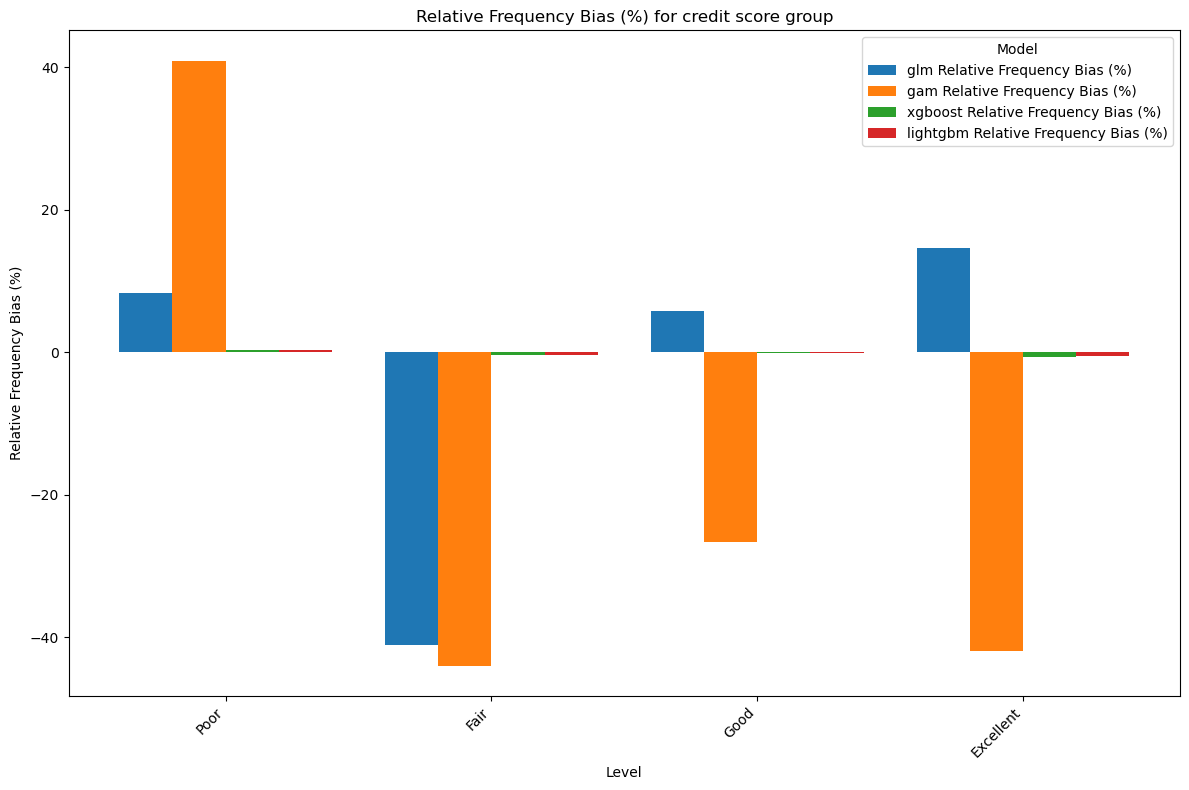

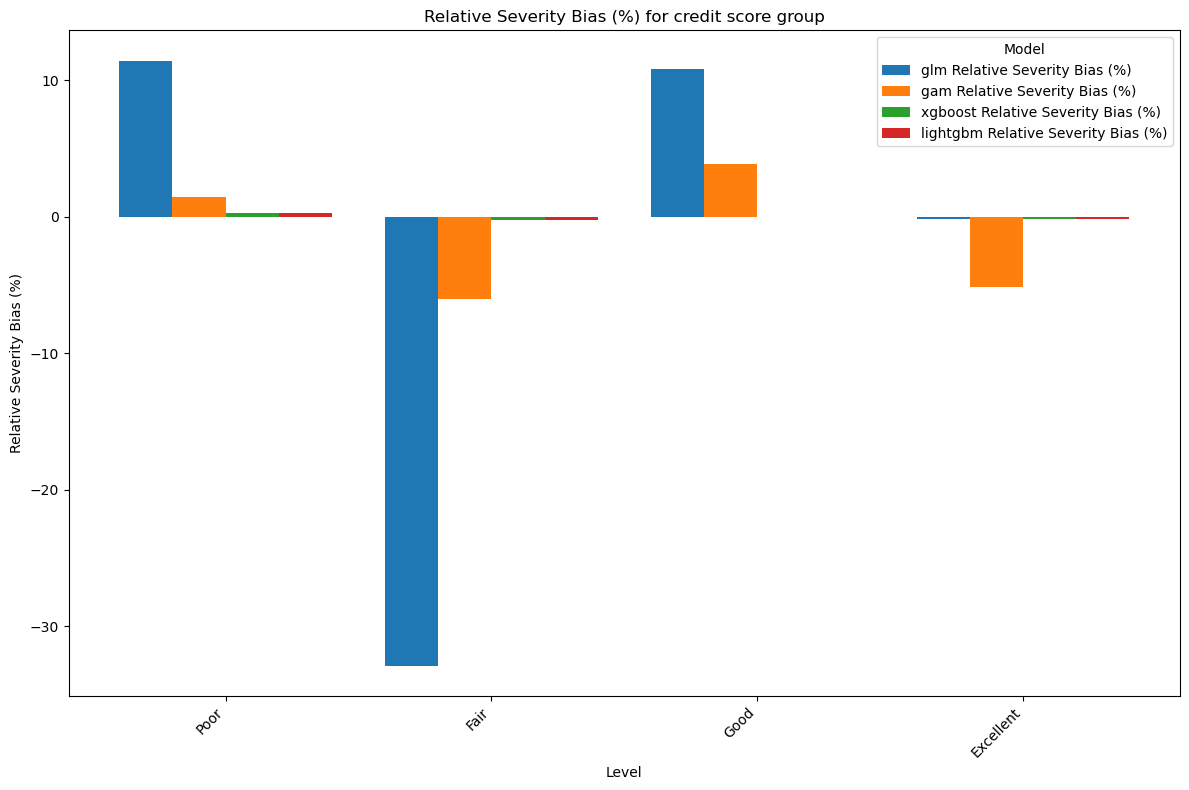

In [45]:
bias_csv_filename = calculate_bias('credit_score_group_summary_results.csv')
# plot_bias_with_grouped_barplots(bias_csv_filename, plot_relative=False)
plot_bias_with_grouped_barplots(bias_csv_filename, plot_relative=True)



# FEATURE IMPORTANCE: For best performing model xgboost


Calculating SHAP values for Frequency model - Group: age_group
SHAP values saved to age_group_shap_values_target_relative_frequency.csv


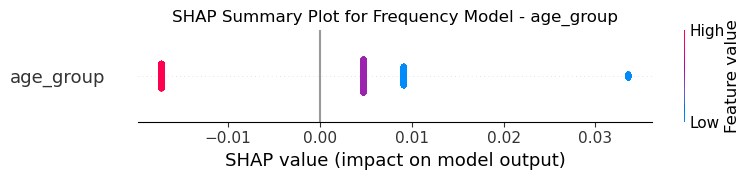


Calculating SHAP values for Severity model - Group: age_group
SHAP values saved to age_group_shap_values_target_severity.csv


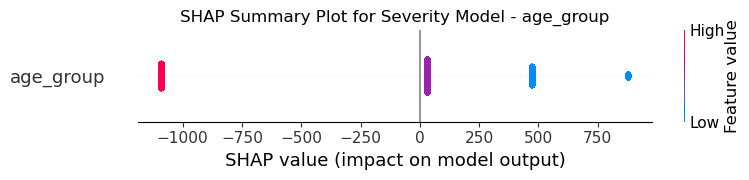


Calculating SHAP values for Frequency model - Group: credit_score_group
SHAP values saved to credit_score_group_shap_values_target_relative_frequency.csv


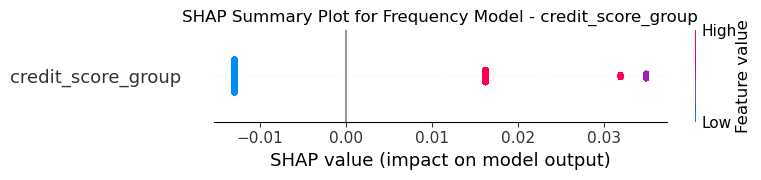


Calculating SHAP values for Severity model - Group: credit_score_group
SHAP values saved to credit_score_group_shap_values_target_severity.csv


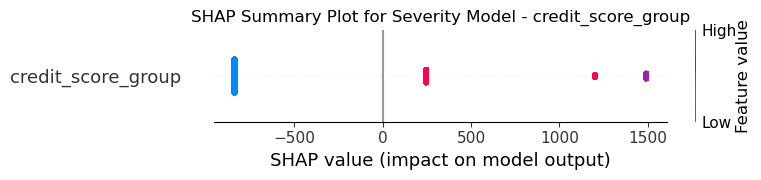


Calculating SHAP values for Frequency model - Group: annual_miles_group
SHAP values saved to annual_miles_group_shap_values_target_relative_frequency.csv


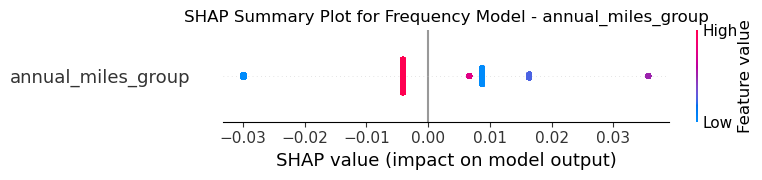


Calculating SHAP values for Severity model - Group: annual_miles_group
SHAP values saved to annual_miles_group_shap_values_target_severity.csv


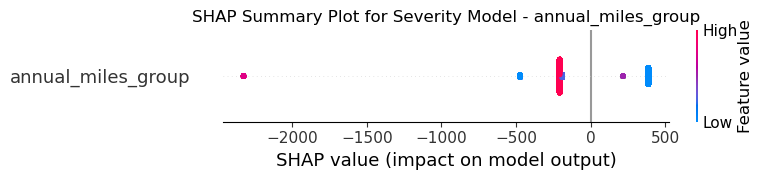


Calculating SHAP values for Frequency model - Group: car_age_group
SHAP values saved to car_age_group_shap_values_target_relative_frequency.csv


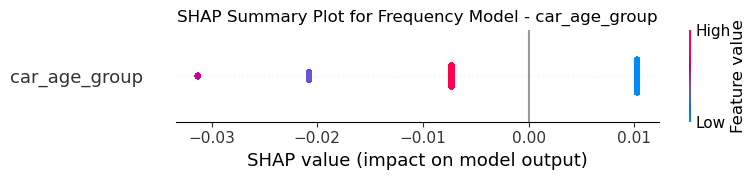


Calculating SHAP values for Severity model - Group: car_age_group
SHAP values saved to car_age_group_shap_values_target_severity.csv


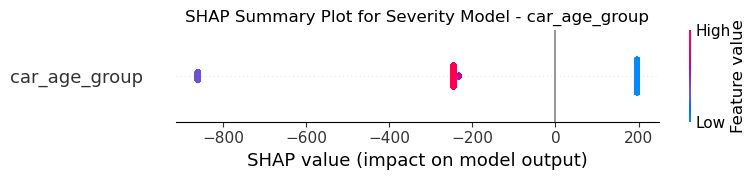


Calculating SHAP values for Frequency model - Group: years_noclaims_group
SHAP values saved to years_noclaims_group_shap_values_target_relative_frequency.csv


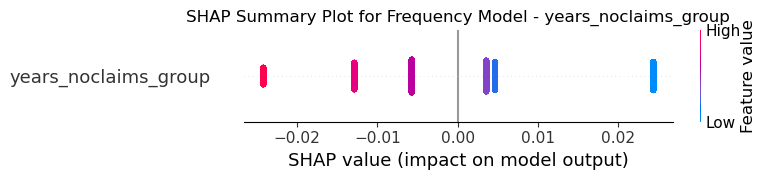


Calculating SHAP values for Severity model - Group: years_noclaims_group
SHAP values saved to years_noclaims_group_shap_values_target_severity.csv


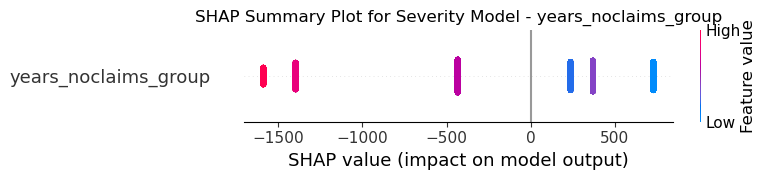

In [1]:
import pandas as pd
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Load pre-trained models for frequency and severity
xgb_models_frequency = {}
xgb_models_severity = {}
groups_of_interest = ['age_group', 'credit_score_group', 'annual_miles_group', 'car_age_group', 'years_noclaims_group']

# Load the models for each group
for group in groups_of_interest:
    # Load frequency model
    model_freq = xgb.XGBRegressor()
    model_freq.load_model(f"{group}_xgb_model.json")  # Assume frequency models have this naming convention
    xgb_models_frequency[group] = model_freq

    # Load severity model
    model_sev = xgb.XGBRegressor()
    model_sev.load_model(f"{group}_xgb_severity_model.json")  # Assume severity models have this naming convention
    xgb_models_severity[group] = model_sev

# Function to calculate SHAP values for frequency or severity
def calculate_shap_with_saved_xgb_models(df, group_column, xgb_model, target_variable):
    # Select relevant columns and encode the group column
    df_group = df[[group_column, 'NB_Claim', 'AMT_Claim']].dropna().copy()
    df_group[group_column] = LabelEncoder().fit_transform(df_group[group_column])

    # Calculate the target variables for frequency and severity
    df_group['actual_claim_counts'] = df_group.groupby(group_column)['NB_Claim'].transform('sum')
    df_group['target_severity'] = df_group.groupby(group_column)['AMT_Claim'].transform('sum') / df_group['actual_claim_counts']
    total_claims_in_group = df_group['NB_Claim'].sum()
    df_group['target_relative_frequency'] = df_group.groupby(group_column)['NB_Claim'].transform('sum') / total_claims_in_group

    # Select the feature and the specified target variable
    X = df_group[[group_column]]
    y = df_group[target_variable]  # Use either 'target_relative_frequency' or 'target_severity'

    # Calculate SHAP values using TreeExplainer
    explainer = shap.TreeExplainer(xgb_model)
    shap_values = explainer.shap_values(X)

    # Save SHAP values and features to a CSV file
    shap_df = pd.DataFrame(shap_values, columns=[f"SHAP_{group_column}"])
    shap_df[group_column] = X[group_column].values
    output_filename = f"{group_column}_shap_values_{target_variable}.csv"
    shap_df.to_csv(output_filename, index=False)
    print(f"SHAP values saved to {output_filename}")

    return shap_values, X, group_column

# Load the prepared dataset
df = pd.read_csv('final_prepared_data.csv')

# Calculate and plot SHAP values for each group for frequency and severity models
for group in groups_of_interest:
    print(f"\nCalculating SHAP values for Frequency model - Group: {group}")
    shap_values_freq, X_freq, group_column = calculate_shap_with_saved_xgb_models(df, group, xgb_models_frequency[group], 'target_relative_frequency')
    # Plot SHAP summary for frequency
    plt.title(f'SHAP Summary Plot for Frequency Model - {group_column}')
    shap.summary_plot(shap_values_freq, X_freq, feature_names=[group_column])
    plt.show()

    print(f"\nCalculating SHAP values for Severity model - Group: {group}")
    shap_values_sev, X_sev, group_column = calculate_shap_with_saved_xgb_models(df, group, xgb_models_severity[group], 'target_severity')
    # Plot SHAP summary for severity
    plt.title(f'SHAP Summary Plot for Severity Model - {group_column}')
    shap.summary_plot(shap_values_sev, X_sev, feature_names=[group_column])
    plt.show()


## Summarize the SHAP Analysis Across Groups

### XGBOOST

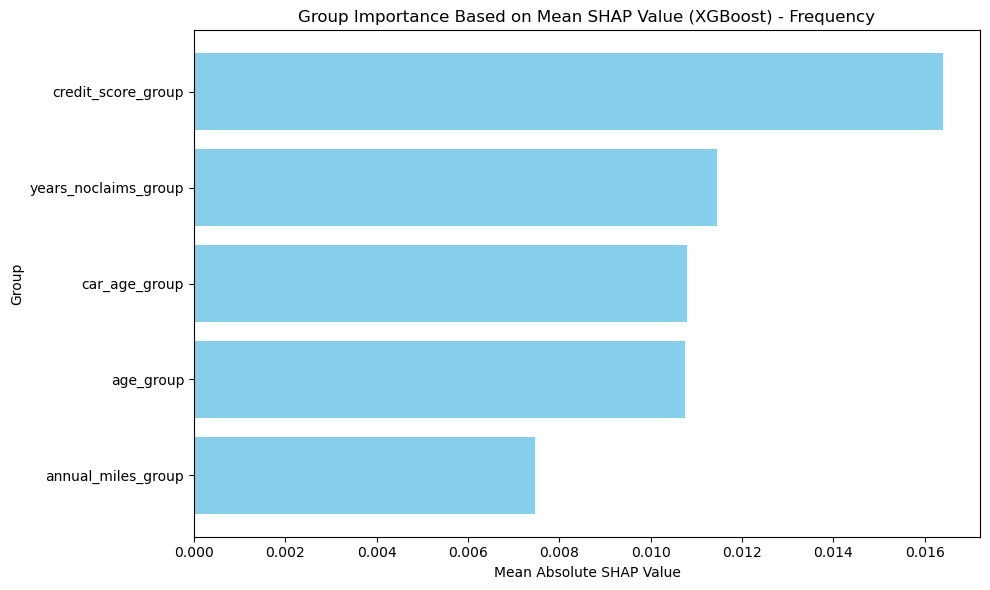

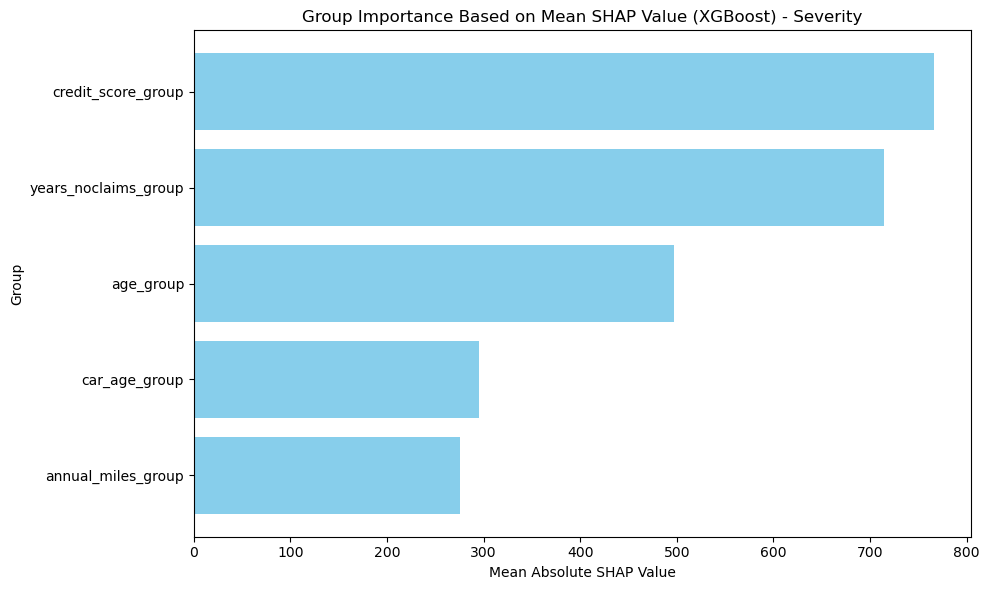

In [53]:
import pandas as pd
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Load pre-trained models
xgb_models_frequency = {}
xgb_models_severity = {}
groups_of_interest = ['age_group', 'credit_score_group', 'annual_miles_group', 'car_age_group', 'years_noclaims_group']

# Load the models
for group in groups_of_interest:
    try:
        model_freq = xgb.XGBRegressor()
        model_freq.load_model(f"{group}_xgb_model.json")  # Frequency model
        xgb_models_frequency[group] = model_freq

        model_sev = xgb.XGBRegressor()
        model_sev.load_model(f"{group}_xgb_severity_model.json")  # Severity model
        xgb_models_severity[group] = model_sev

    except Exception as e:
        print(f"Error loading model for {group}: {e}")

def calculate_targets(df, group_column):
    """Calculate target relative frequency and severity."""
    df_group = df[[group_column, 'NB_Claim', 'AMT_Claim']].dropna().copy()
    df_group[group_column] = LabelEncoder().fit_transform(df_group[group_column])

    # Calculate actual claim counts within the level
    df_group['actual_claim_counts'] = df_group.groupby(group_column)['NB_Claim'].transform('sum')
    
    # Calculate severity as total claim losses within the level divided by total claim counts within the level
    df_group['target_severity'] = df_group.groupby(group_column)['AMT_Claim'].transform('sum') / df_group['actual_claim_counts']
    
    # Calculate relative frequency as the mean of the number of claims in the level
    df_group['target_relative_frequency'] = df_group.groupby(group_column)['NB_Claim'].transform('mean')

    return df_group

def calculate_shap_values_for_group(df, group_column, model, target):
    df_group = calculate_targets(df, group_column)
    
    X = df_group[[group_column]]
    y = df_group[target]

    # Calculate SHAP values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)

    return shap_values, X

# Load the prepared dataset
df = pd.read_csv('final_prepared_data.csv')

# SHAP Analysis for Frequency
shap_summary_freq = pd.DataFrame()
for group in groups_of_interest:
    shap_values_freq, X_freq = calculate_shap_values_for_group(
        df, group, xgb_models_frequency.get(group), 'target_relative_frequency'
    )
    if shap_values_freq is not None:
        mean_abs_shap_freq = pd.DataFrame({
            'Group': group,
            'Mean SHAP Value': np.abs(shap_values_freq).mean(axis=0)
        })
        shap_summary_freq = pd.concat([shap_summary_freq, mean_abs_shap_freq], axis=0)

# SHAP Analysis for Severity
shap_summary_sev = pd.DataFrame()
for group in groups_of_interest:
    shap_values_sev, X_sev = calculate_shap_values_for_group(
        df, group, xgb_models_severity.get(group), 'target_severity'
    )
    if shap_values_sev is not None:
        mean_abs_shap_sev = pd.DataFrame({
            'Group': group,
            'Mean SHAP Value': np.abs(shap_values_sev).mean(axis=0)
        })
        shap_summary_sev = pd.concat([shap_summary_sev, mean_abs_shap_sev], axis=0)

# Save and visualize SHAP summary for frequency
shap_summary_freq = shap_summary_freq.sort_values(by='Mean SHAP Value', ascending=False)
shap_summary_freq.to_csv('xgb_shap_group_importance_summary_frequency.csv', index=False)
plt.figure(figsize=(10, 6))
plt.barh(shap_summary_freq['Group'], shap_summary_freq['Mean SHAP Value'], color='skyblue')
plt.xlabel('Mean Absolute SHAP Value')
plt.ylabel('Group')
plt.title('Group Importance Based on Mean SHAP Value (XGBoost) - Frequency')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Save and visualize SHAP summary for severity
shap_summary_sev = shap_summary_sev.sort_values(by='Mean SHAP Value', ascending=False)
shap_summary_sev.to_csv('xgb_shap_group_importance_summary_severity.csv', index=False)
plt.figure(figsize=(10, 6))
plt.barh(shap_summary_sev['Group'], shap_summary_sev['Mean SHAP Value'], color='skyblue')
plt.xlabel('Mean Absolute SHAP Value')
plt.ylabel('Group')
plt.title('Group Importance Based on Mean SHAP Value (XGBoost) - Severity')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


## FEATURE IMPORTANCE GAM WITH SMOOTH FUNCTION

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--


Training and predicting for group 'age_group'


  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:03
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:02
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:01
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:01
 45% (5 of 11) |###########              | Elapsed Time: 0:00:01 ETA:   0:00:01
 54% (6 of 11) |#############            | Elapsed Time: 0:00:01 ETA:   0:00:01
 63% (7 of 11) |###############          | Elapsed Time: 0:00:01 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:01 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:02 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:02 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Frequency RMSE for group 'age_group': 0.00010508235140824237
Severity RMSE for group 'age_group': 13.928380705533216


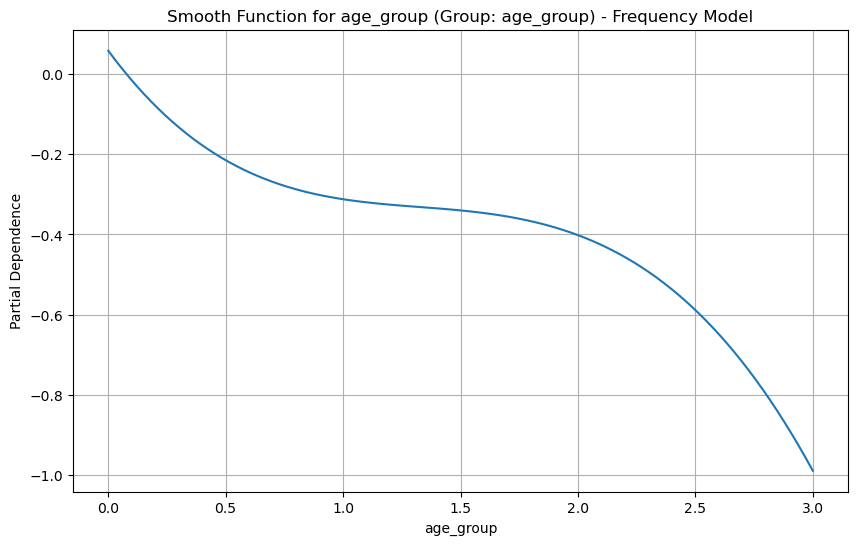

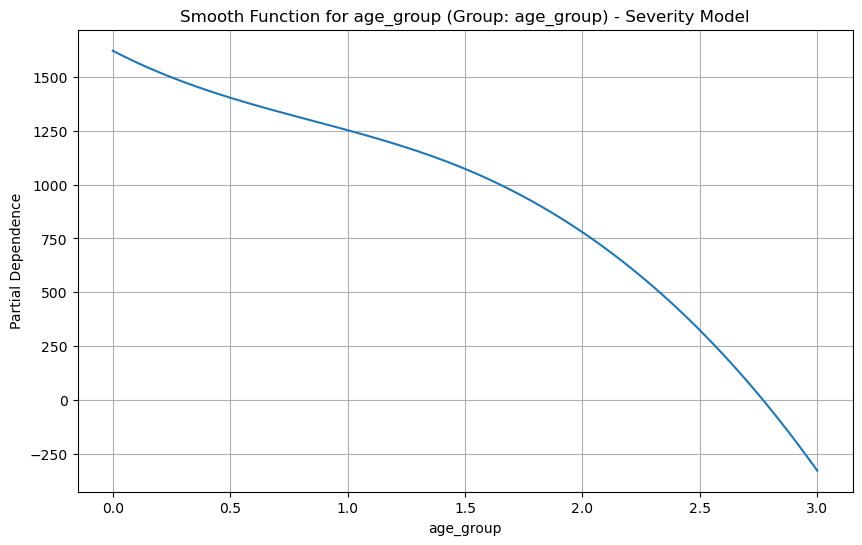

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--


Training and predicting for group 'credit_score_group'


  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:01
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:01
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:01
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:01
 45% (5 of 11) |###########              | Elapsed Time: 0:00:01 ETA:   0:00:01
 54% (6 of 11) |#############            | Elapsed Time: 0:00:01 ETA:   0:00:01
 63% (7 of 11) |###############          | Elapsed Time: 0:00:01 ETA:   0:00:01
 72% (8 of 11) |##################       | Elapsed Time: 0:00:02 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:02 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:02 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:03 Time:  0:00:03


Frequency RMSE for group 'credit_score_group': 7.845790401670414e-05
Severity RMSE for group 'credit_score_group': 142.36626912699373


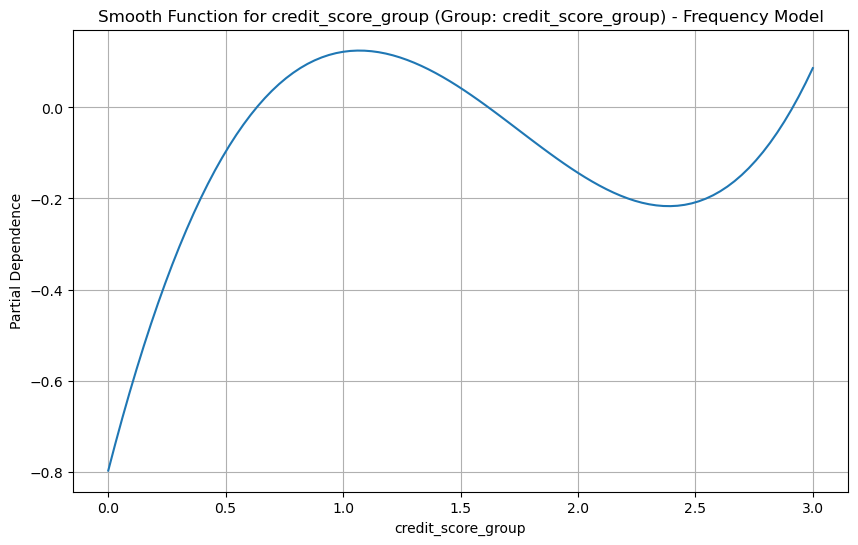

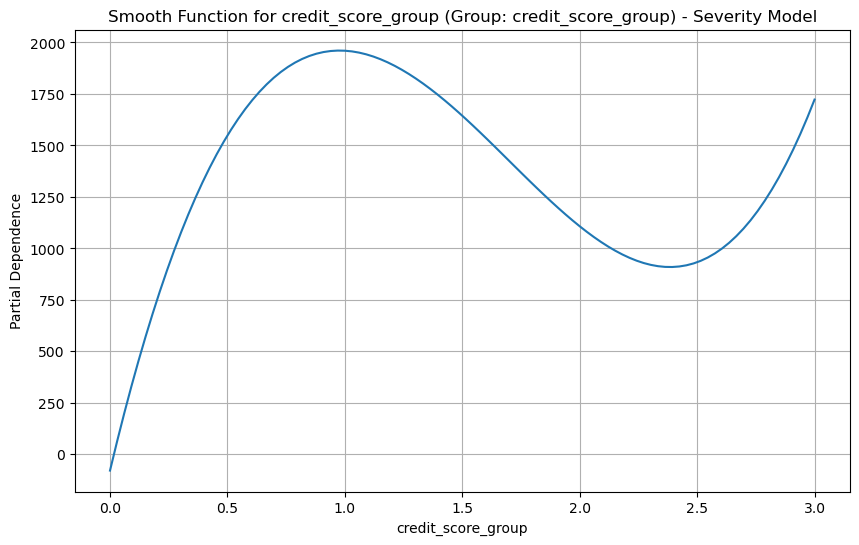

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:01


Training and predicting for group 'annual_miles_group'


 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:01
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:01
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:01
 45% (5 of 11) |###########              | Elapsed Time: 0:00:01 ETA:   0:00:01
 54% (6 of 11) |#############            | Elapsed Time: 0:00:01 ETA:   0:00:01
 63% (7 of 11) |###############          | Elapsed Time: 0:00:02 ETA:   0:00:02
 72% (8 of 11) |##################       | Elapsed Time: 0:00:03 ETA:   0:00:01
 81% (9 of 11) |####################     | Elapsed Time: 0:00:03 ETA:   0:00:01
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:03 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:04 Time:  0:00:04


Frequency RMSE for group 'annual_miles_group': 0.001758137512092545
Severity RMSE for group 'annual_miles_group': 155.7112852407971


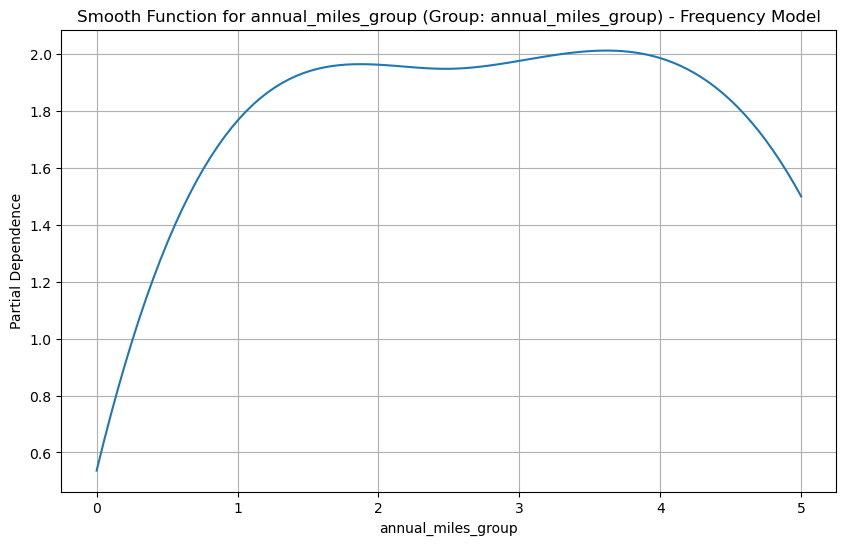

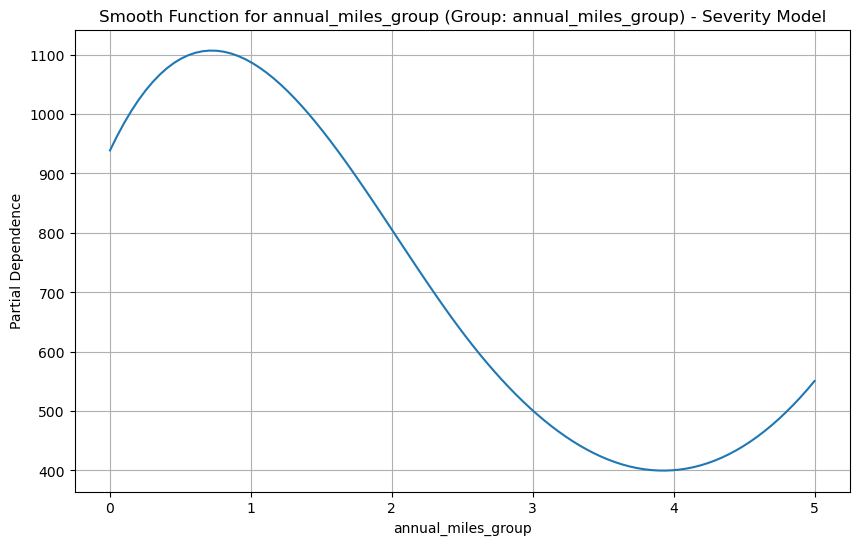

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:01


Training and predicting for group 'car_age_group'


 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:01
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:01
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:01
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:01
 54% (6 of 11) |#############            | Elapsed Time: 0:00:01 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:01 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:01 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:01 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:02 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Frequency RMSE for group 'car_age_group': 0.00013760088186703896
Severity RMSE for group 'car_age_group': 39.69665170187454


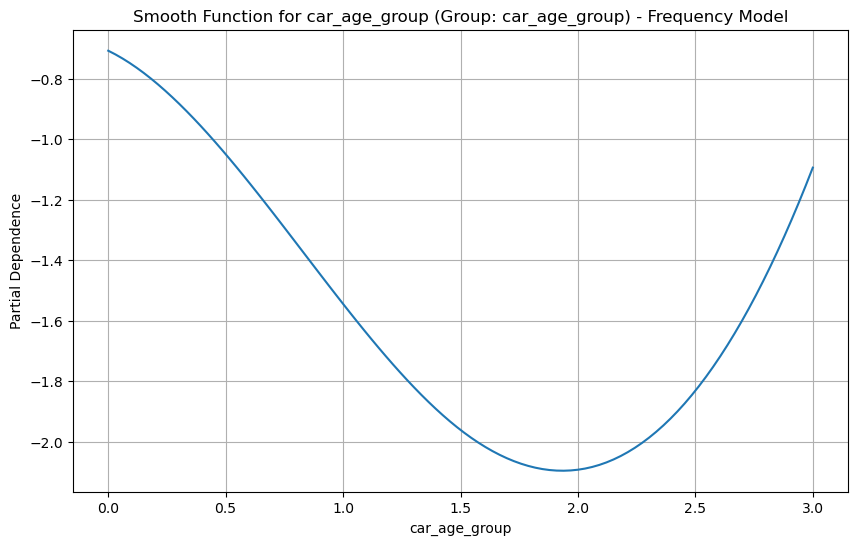

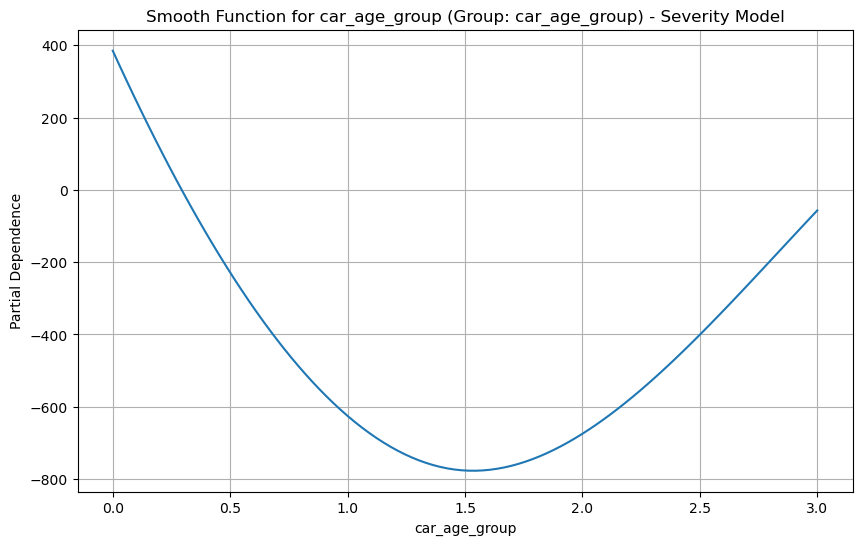

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:01


Training and predicting for group 'years_noclaims_group'


 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:01
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:01
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:01
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:01
 54% (6 of 11) |#############            | Elapsed Time: 0:00:01 ETA:   0:00:01
 63% (7 of 11) |###############          | Elapsed Time: 0:00:01 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:01 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:01 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:02 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Frequency RMSE for group 'years_noclaims_group': 0.0014404907207486548
Severity RMSE for group 'years_noclaims_group': 132.22757415328363


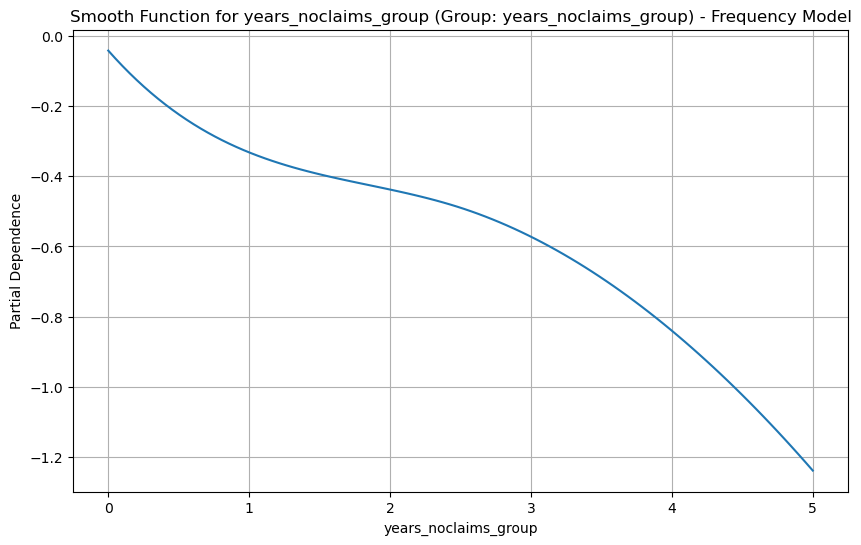

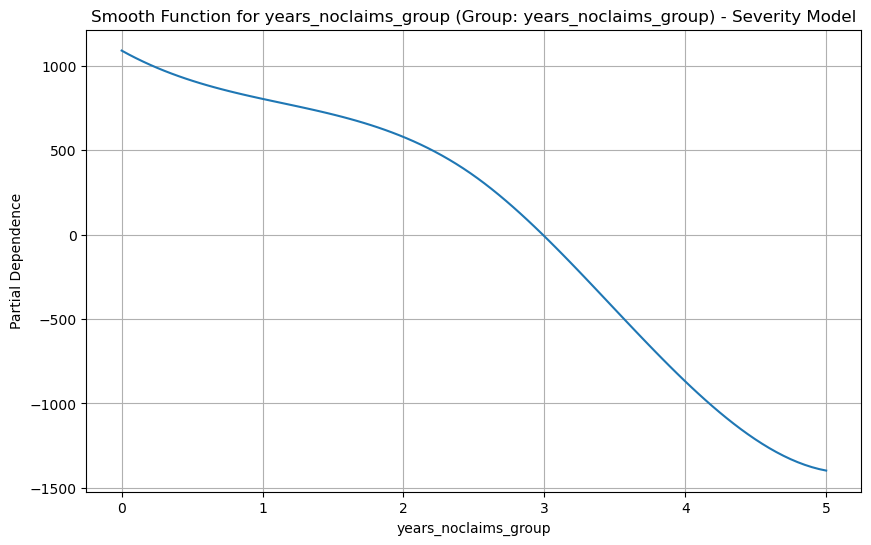

Results saved to 'gam_group_prediction_results.csv'


In [2]:
import pandas as pd
import numpy as np
from pygam import PoissonGAM, LinearGAM, s
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Function to train and predict using GAM for a specific group
def train_and_predict_gam_group(df, group_column):
    df_group = df[[group_column, 'NB_Claim', 'AMT_Claim']].dropna().copy()
    
    # Encode the group column
    df_group[group_column] = LabelEncoder().fit_transform(df_group[group_column])

    df_group['members_in_level'] = df_group.groupby(group_column)[group_column].transform('count')
    df_group['actual_claim_counts'] = df_group.groupby(group_column)['NB_Claim'].transform('sum')
    df_group['target_severity'] = df_group.groupby(group_column)['AMT_Claim'].transform('sum') / df_group['actual_claim_counts']
    df_group['target_relative_frequency'] = df_group.groupby(group_column)['NB_Claim'].transform('mean')

    # Prepare features and targets for claim frequency
    X = df_group[[group_column]].values
    y_claims = df_group['target_relative_frequency'].values
    
    # Fit the PoissonGAM model for frequency prediction
    gam_freq = PoissonGAM(s(0, n_splines=5, lam=0.6)).gridsearch(X, y_claims)
    df_group['predicted_claims'] = gam_freq.predict(X)

    # Calculate RMSE for frequency prediction
    frequency_rmse = np.sqrt(np.mean((df_group['target_relative_frequency'] - df_group['predicted_claims'])**2))
    print(f"Frequency RMSE for group '{group_column}': {frequency_rmse}")

    # Fit the LinearGAM model for severity prediction (only if there are non-zero claims)
    df_non_zero_claims = df_group[df_group['NB_Claim'] > 0].copy()
    if not df_non_zero_claims.empty:
        X_sev = df_non_zero_claims[[group_column]].values
        y_sev = df_non_zero_claims['target_severity'].values

        # Fit the LinearGAM model for severity prediction
        gam_sev = LinearGAM(s(0, n_splines=5, lam=0.6)).fit(X_sev, y_sev)
        df_non_zero_claims['predicted_severity'] = gam_sev.predict(X_sev)

        # Calculate RMSE for severity prediction
        severity_rmse = np.sqrt(np.mean((df_non_zero_claims['target_severity'] - df_non_zero_claims['predicted_severity'])**2))
        print(f"Severity RMSE for group '{group_column}': {severity_rmse}")
    else:
        df_non_zero_claims['predicted_severity'] = None
        severity_rmse = None
        print(f"No severity RMSE for group '{group_column}' as there are no non-zero claims.")

    # Combine the results for frequency and severity
    results = df_group.groupby(group_column).agg(
        actual_frequency=('target_relative_frequency', 'mean'),
        predicted_frequency=('predicted_claims', 'mean'),
    ).reset_index()

    if not df_non_zero_claims.empty:
        severity_results = df_non_zero_claims.groupby(group_column).agg(
            actual_severity=('target_severity', 'mean'),
            predicted_severity=('predicted_severity', 'mean')
        ).reset_index()
        results = pd.merge(results, severity_results, on=group_column, how='left')

    # Save the results to a CSV file
    results['model'] = 'gam'
    results['group'] = group_column
    results = results[['model', 'group', group_column, 'actual_frequency', 'predicted_frequency', 'actual_severity', 'predicted_severity']]
    results.rename(columns={group_column: 'level'}, inplace=True)

    return results, gam_freq, gam_sev


# Function to plot the smooth function for a GAM model
def plot_gam_smooth_function(gam, group_column, group_name, model_type='Frequency'):
    XX = gam.generate_X_grid(term=0)
    plt.figure(figsize=(10, 6))
    plt.plot(XX[:, 0], gam.partial_dependence(term=0, X=XX))
    plt.title(f"Smooth Function for {group_name} (Group: {group_column}) - {model_type} Model")
    plt.xlabel(group_column)
    plt.ylabel("Partial Dependence")
    plt.grid(True)
    plt.show()

# Load the prepared dataset from CSV
df = pd.read_csv('final_prepared_data.csv')

# Define the groups of interest
groups_of_interest = ['age_group', 'credit_score_group', 'annual_miles_group', 'car_age_group', 'years_noclaims_group']

# Apply the training and prediction for each group
results_list = []
for group in groups_of_interest:
    print(f"Training and predicting for group '{group}'")
    results, gam_freq, gam_sev = train_and_predict_gam_group(df, group)
    results_list.append(results)

    # Plot the smooth function for frequency model
    if gam_freq is not None:
        plot_gam_smooth_function(gam_freq, group, group, model_type='Frequency')
    
    # Plot the smooth function for severity model (if available)
    if gam_sev is not None:
        plot_gam_smooth_function(gam_sev, group, group, model_type='Severity')

# Combine results and save to a CSV file
final_results = pd.concat(results_list, axis=0)
final_results.to_csv('gam_group_prediction_results.csv', index=False)
print("Results saved to 'gam_group_prediction_results.csv'")
